In [3]:
# Importing Libraries
# We will use the following libraries:
# - `pandas` for data manipulation
# - `numpy` for numerical operations
# - `matplotlib` and `seaborn` for visualization
# - `sklearn` for the implementation of decision trees

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
dataframe = pd.read_csv('data_resampled.csv')
# Display the first few rows of the dataframe
print(dataframe.head())
# Display the shape of the dataframe
print(dataframe.shape)

   Application order  Daytime/evening attendance  \
0                  5                           1   
1                  1                           1   
2                  5                           1   
3                  2                           1   
4                  1                           0   

   Previous qualification (grade)  Admission grade  Displaced  Debtor  \
0                           122.0            127.3          1       0   
1                           160.0            142.5          1       0   
2                           122.0            124.8          1       0   
3                           122.0            119.6          1       0   
4                           100.0            141.5          0       0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       1                   0                 20   
1                        0       1                   0                 19   
2                

In [5]:
# Load the dataset
dataframe = pd.read_csv('data_resampled.csv')
dataframe.head(10)

# convert the dataframe to a a pandas dataframe for easier manipulation
dataframe = pd.DataFrame(dataframe)

# target variable
target = dataframe['Target']

# features
features = dataframe.drop(columns=['Target'])

target.isna().sum()
# contAR TARGET TYPE
target.value_counts()

Target
2    2500
0    2200
1    2000
Name: count, dtype: int64

In [6]:
target = dataframe['Target']
target_names = ['Dropout', 'Enrolled', 'Graduate']
features = dataframe.drop(columns=['Target'])


#   División del dataset: 80% train / 20% test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from graphviz import Source

# Asignar correctamente
X = features
y =  target
target_names = ['Dropout', 'Enrolled', 'Graduate']

# División 80/20 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## GINI tree: Best tree based on accuracy

Mejor configuración según accuracy :
max_depth             6.000000
min_samples_leaf     60.000000
min_samples_split    20.000000
accuracy              0.709701
Name: 140, dtype: float64


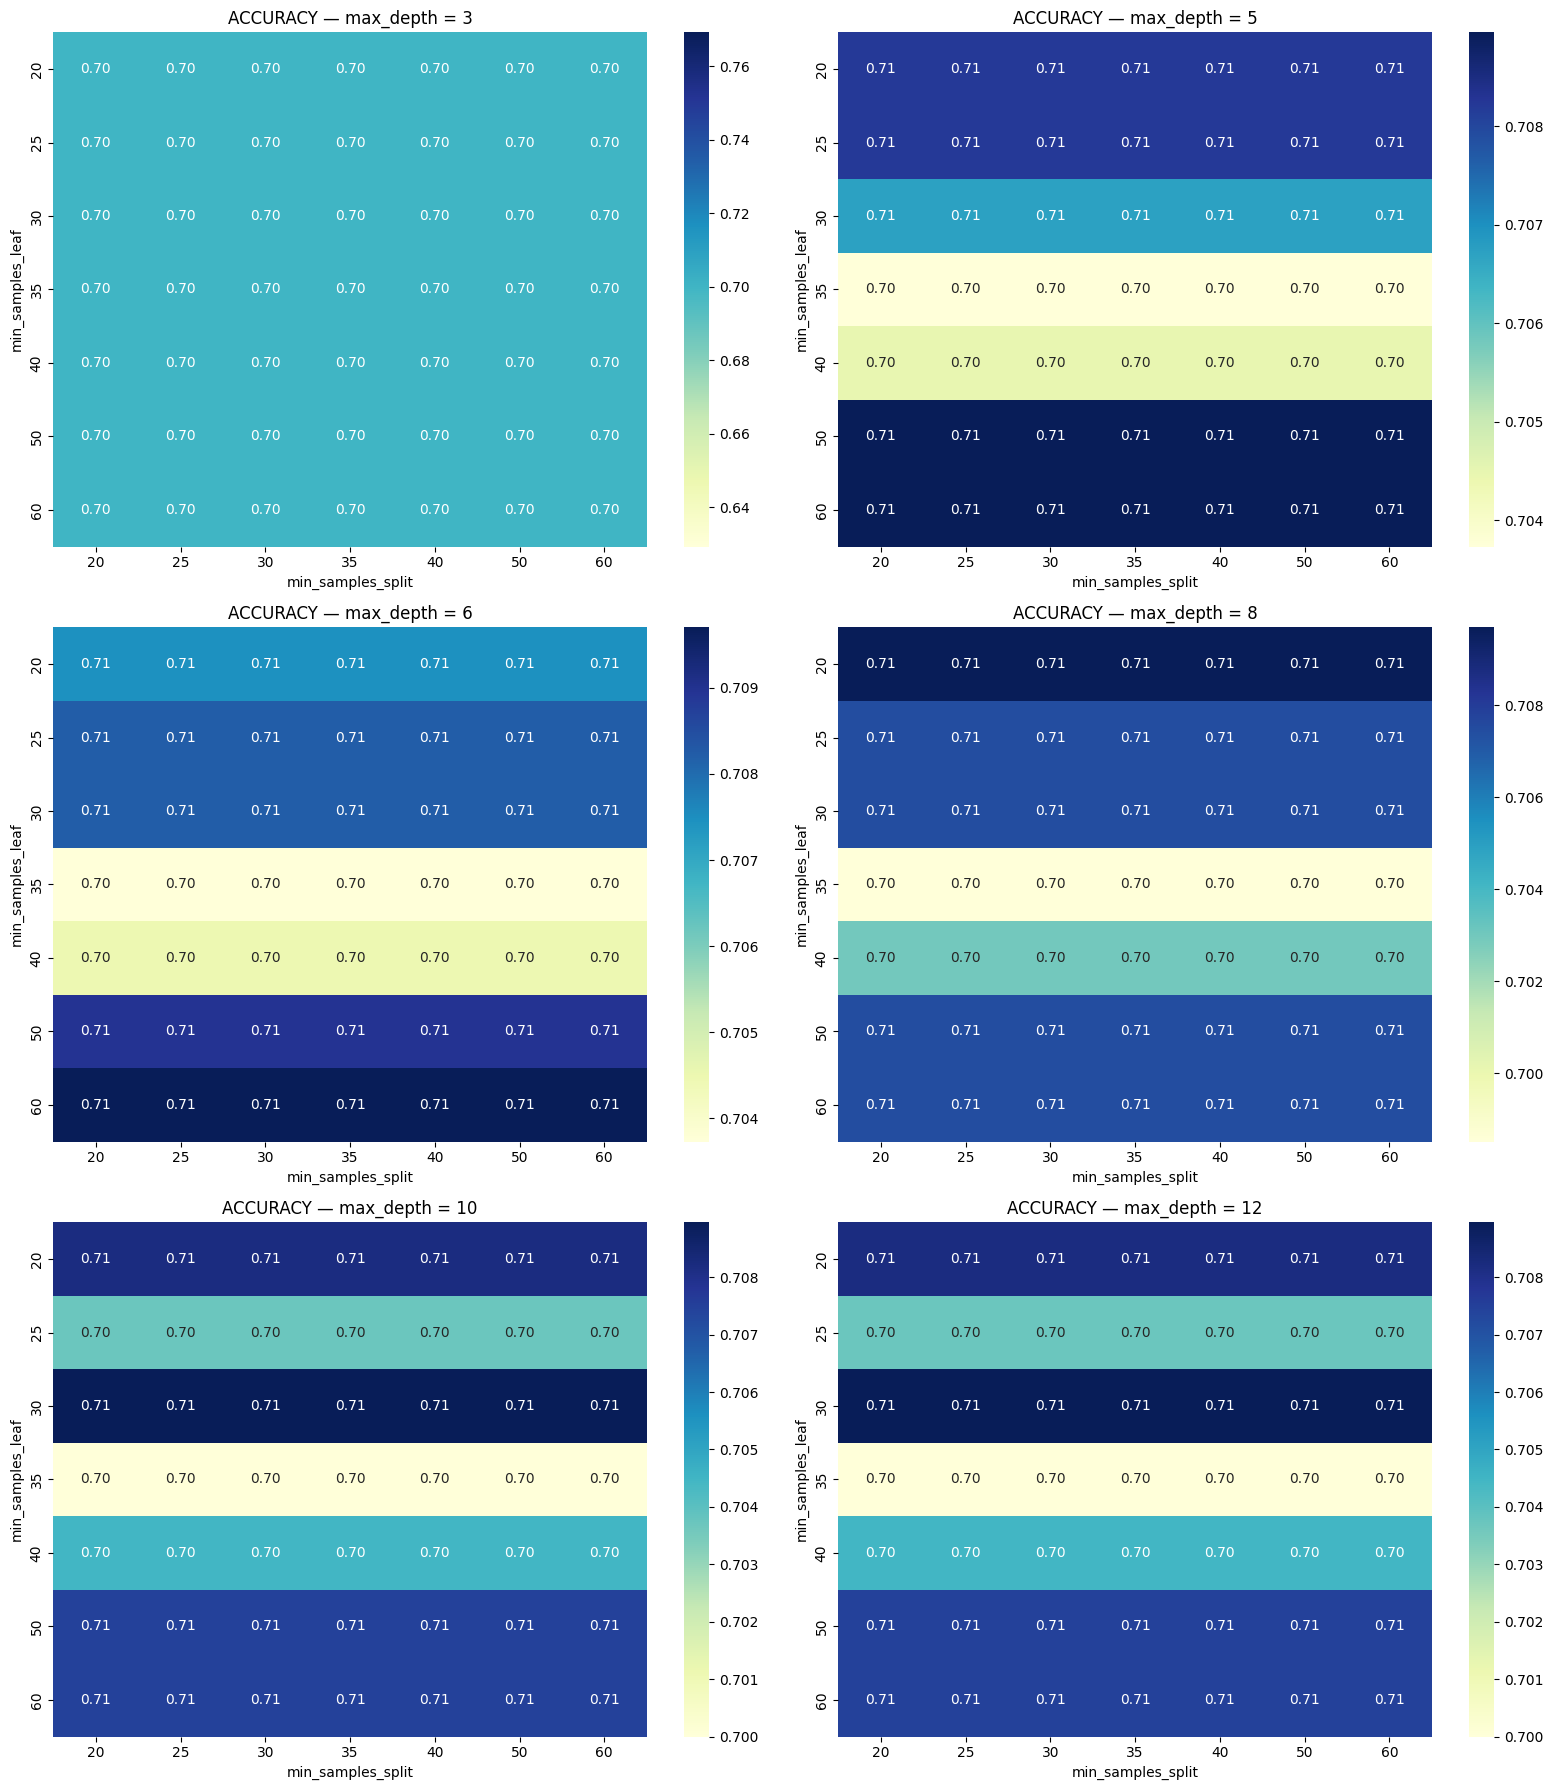


Accuracy del mejor modelo:
0.7097014925373134

Matriz de confusión del mejor modelo:
[[296  87  57]
 [ 67 225 108]
 [ 17  53 430]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.78      0.67      0.72       440
    Enrolled       0.62      0.56      0.59       400
    Graduate       0.72      0.86      0.79       500

    accuracy                           0.71      1340
   macro avg       0.71      0.70      0.70      1340
weighted avg       0.71      0.71      0.71      1340



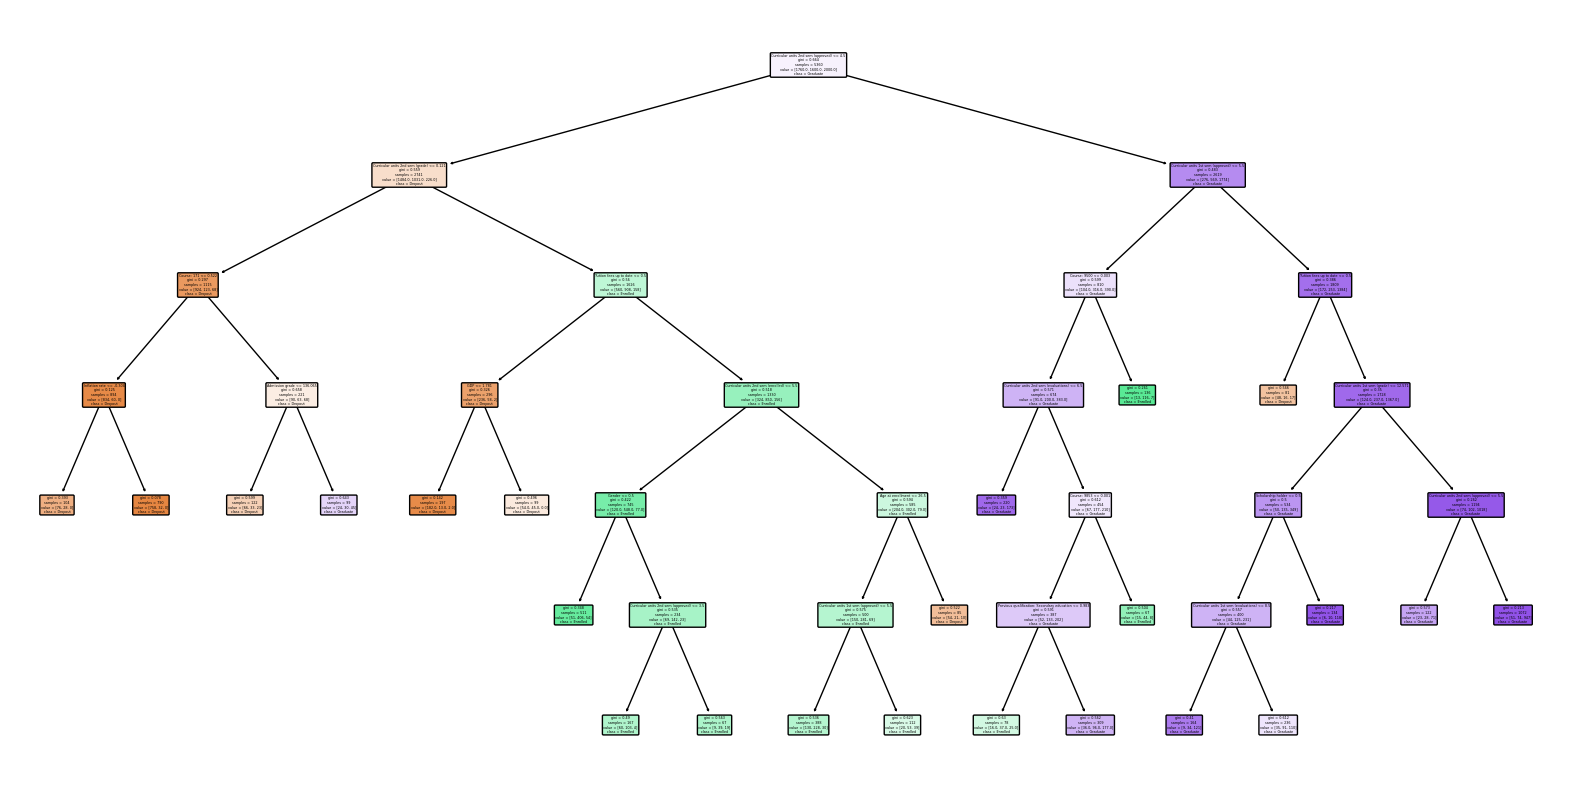

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'accuracy'  # cambia según necesidad

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='gini',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='gini',  
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("dt_best_accuracy_tree.svg", format='svg')
plt.show()

###   GINI tree: Best tree based on recall

Mejor configuración según recall :
max_depth             8.000000
min_samples_leaf     20.000000
min_samples_split    20.000000
recall                0.702242
Name: 147, dtype: float64


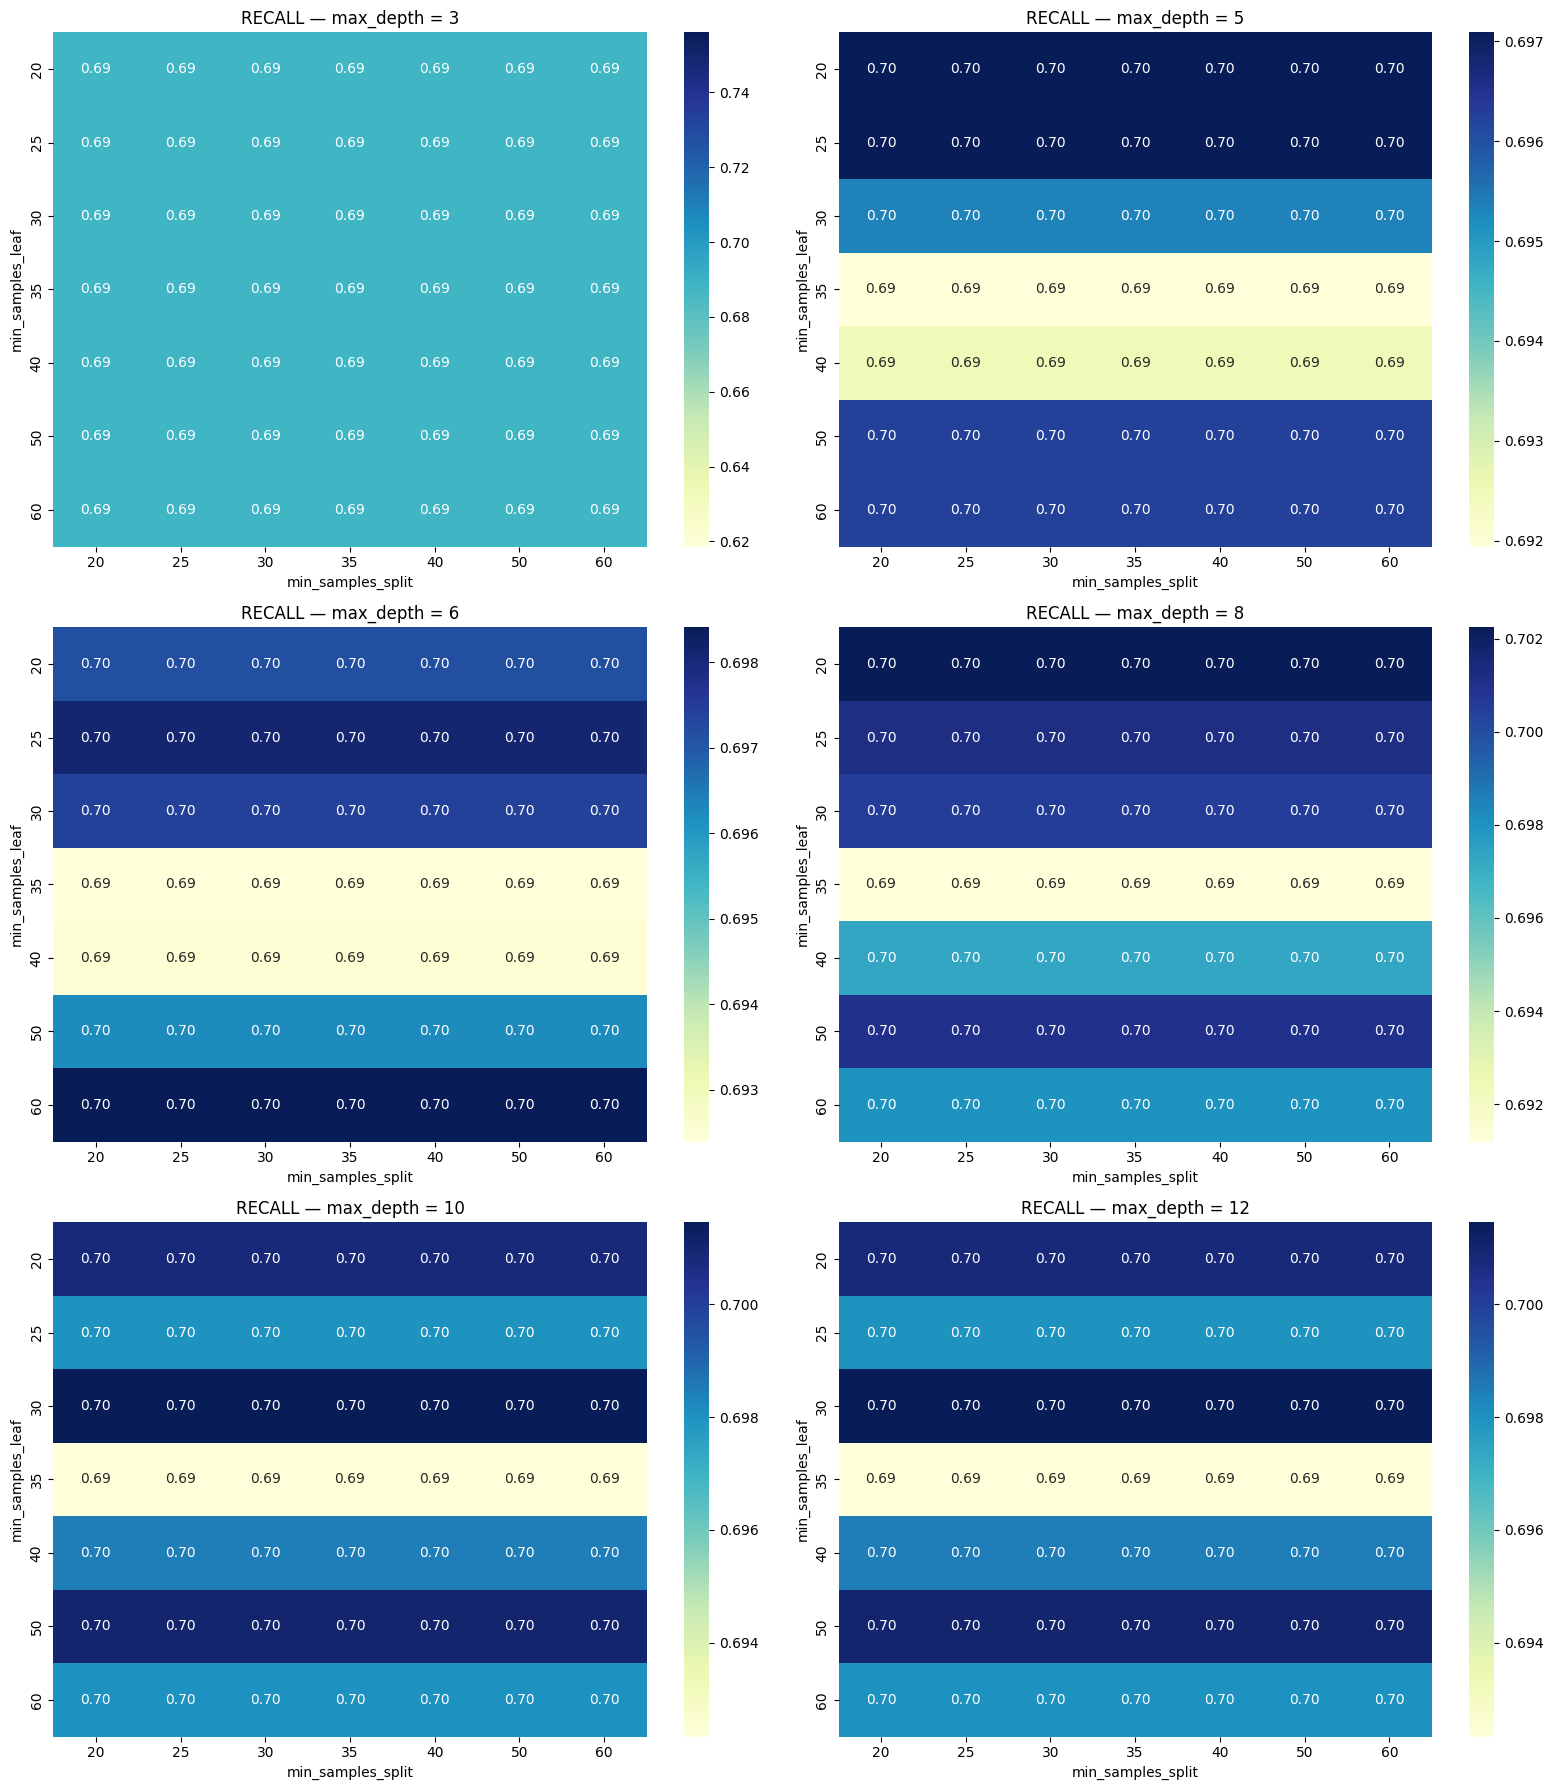


Accuracy del mejor modelo:
0.7097014925373134

Matriz de confusión del mejor modelo:
[[296 101  43]
 [ 71 248  81]
 [ 21  72 407]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.76      0.67      0.71       440
    Enrolled       0.59      0.62      0.60       400
    Graduate       0.77      0.81      0.79       500

    accuracy                           0.71      1340
   macro avg       0.71      0.70      0.70      1340
weighted avg       0.71      0.71      0.71      1340



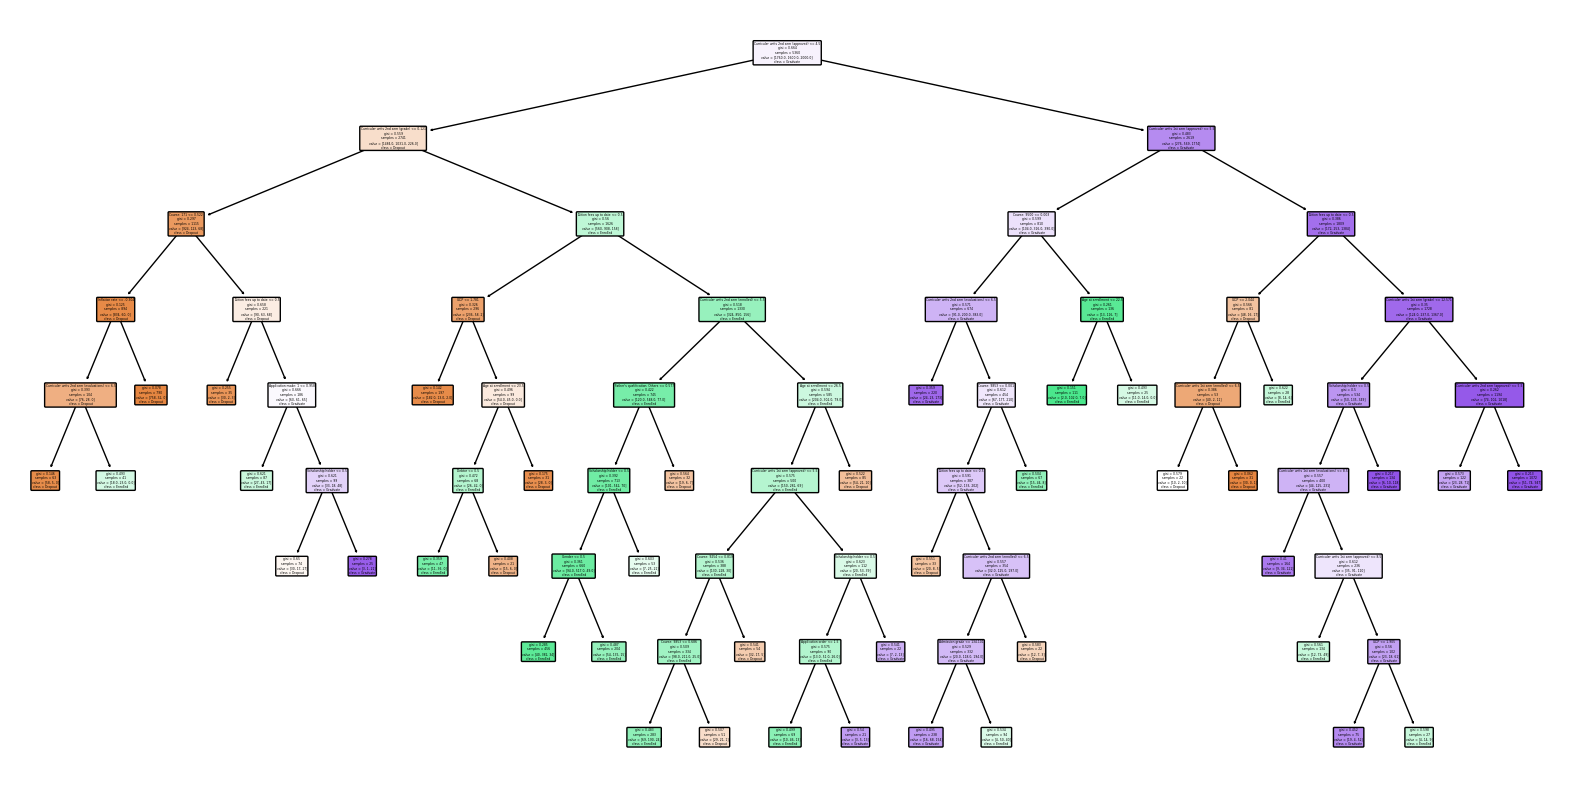

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'recall'  # cambia según necesidad

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='gini',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='gini',  # o 'entropy' si prefieres
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("gini_recall_tree.svg", format='svg')
plt.show()



###   GINI tree: Best tree based on  precision

Mejor configuración según precision :
max_depth             5.000000
min_samples_leaf     20.000000
min_samples_split    20.000000
precision             0.714012
Name: 49, dtype: float64


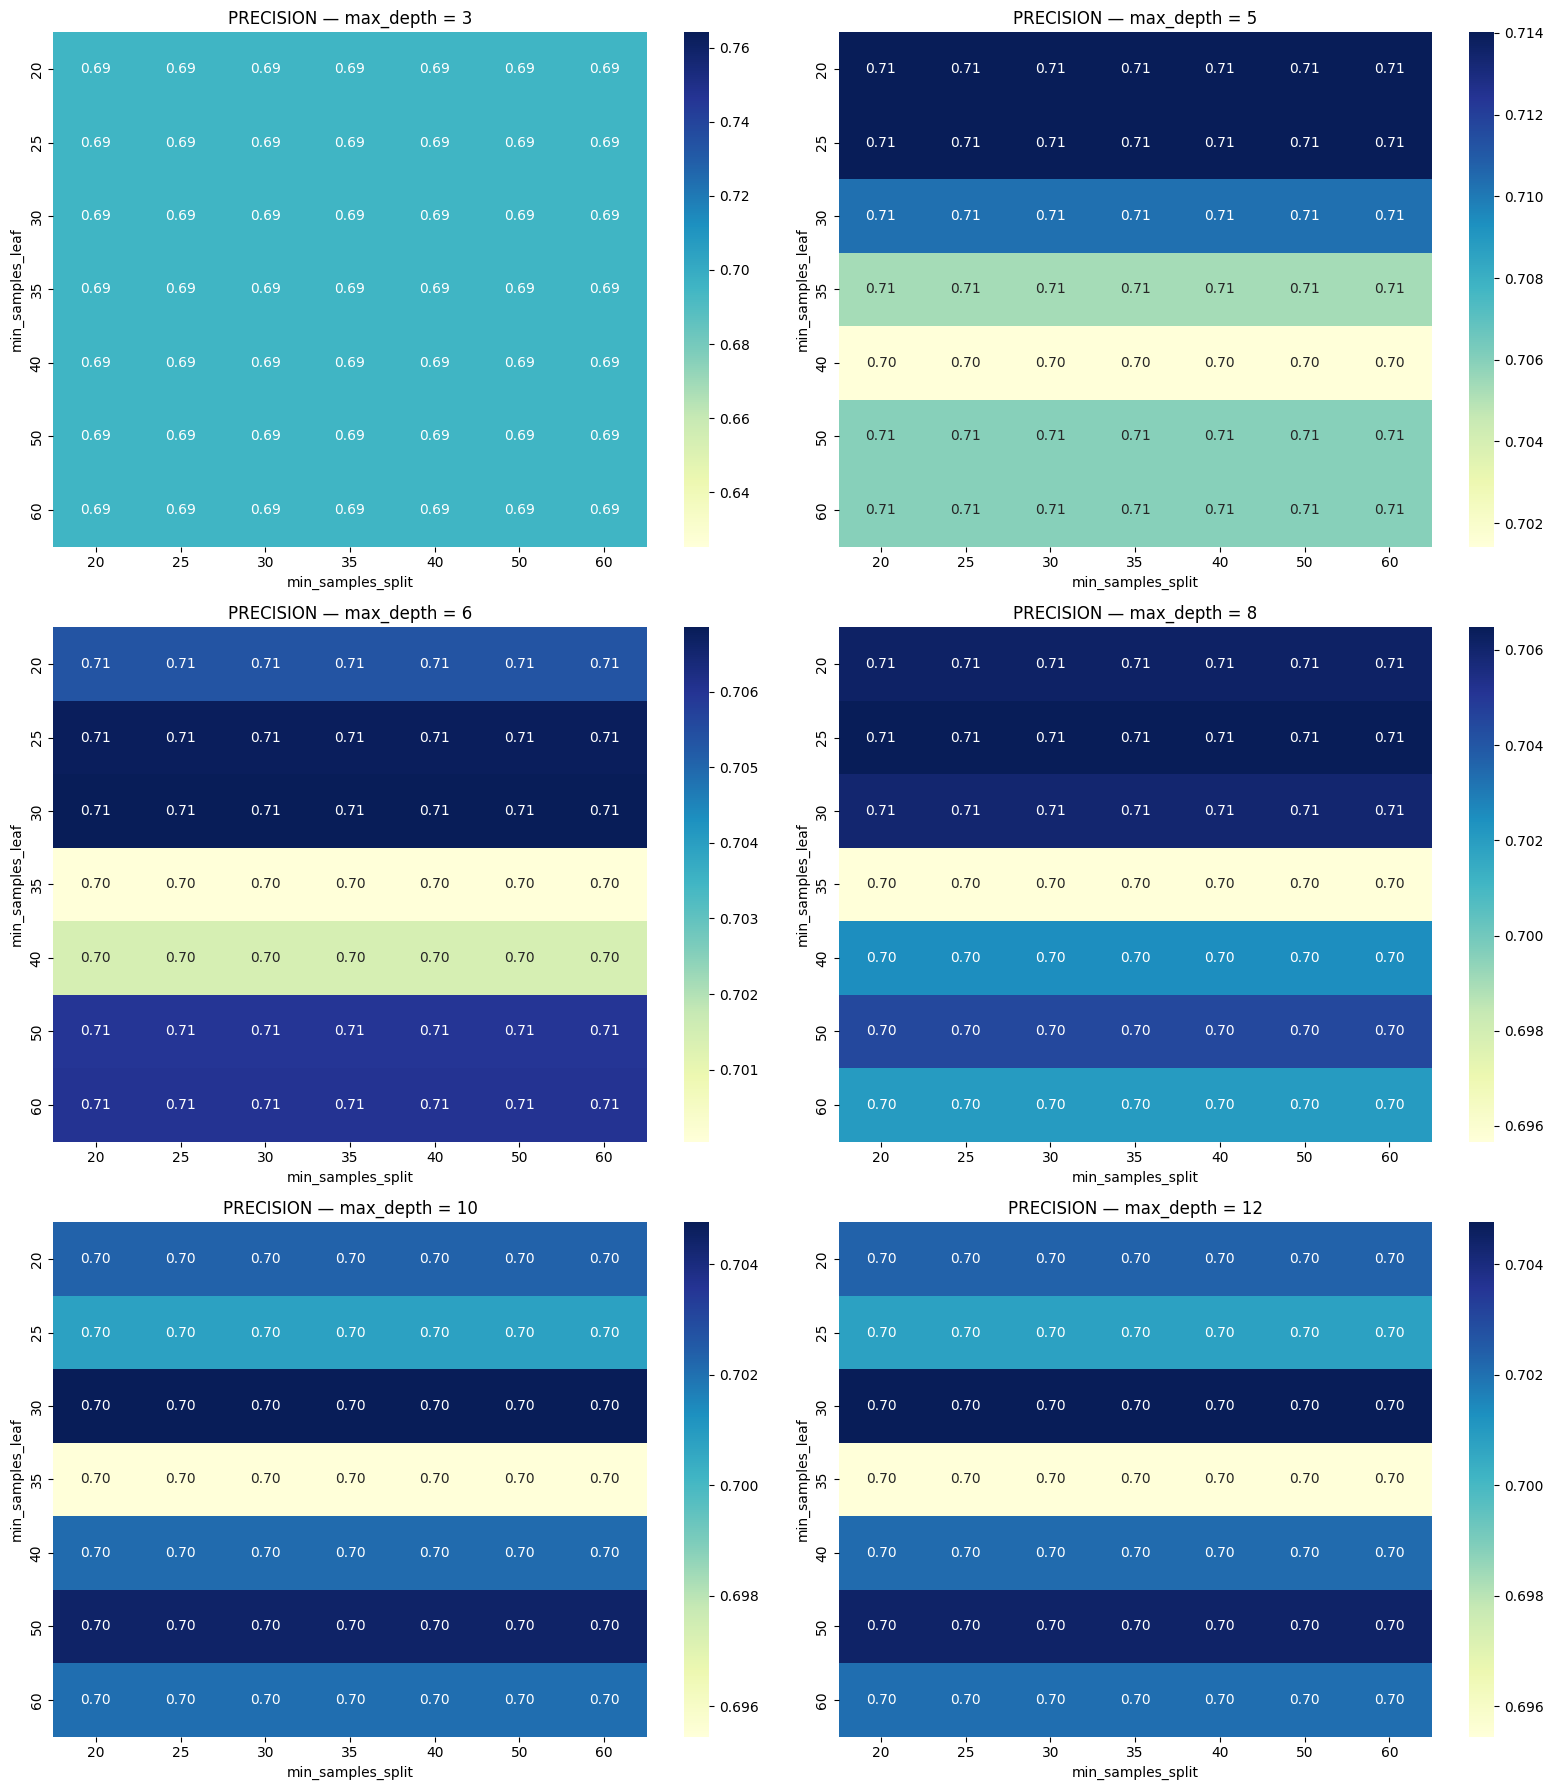


Accuracy del mejor modelo:
0.7082089552238806

Matriz de confusión del mejor modelo:
[[276 105  59]
 [ 46 236 118]
 [ 10  53 437]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.83      0.63      0.72       440
    Enrolled       0.60      0.59      0.59       400
    Graduate       0.71      0.87      0.78       500

    accuracy                           0.71      1340
   macro avg       0.71      0.70      0.70      1340
weighted avg       0.72      0.71      0.70      1340



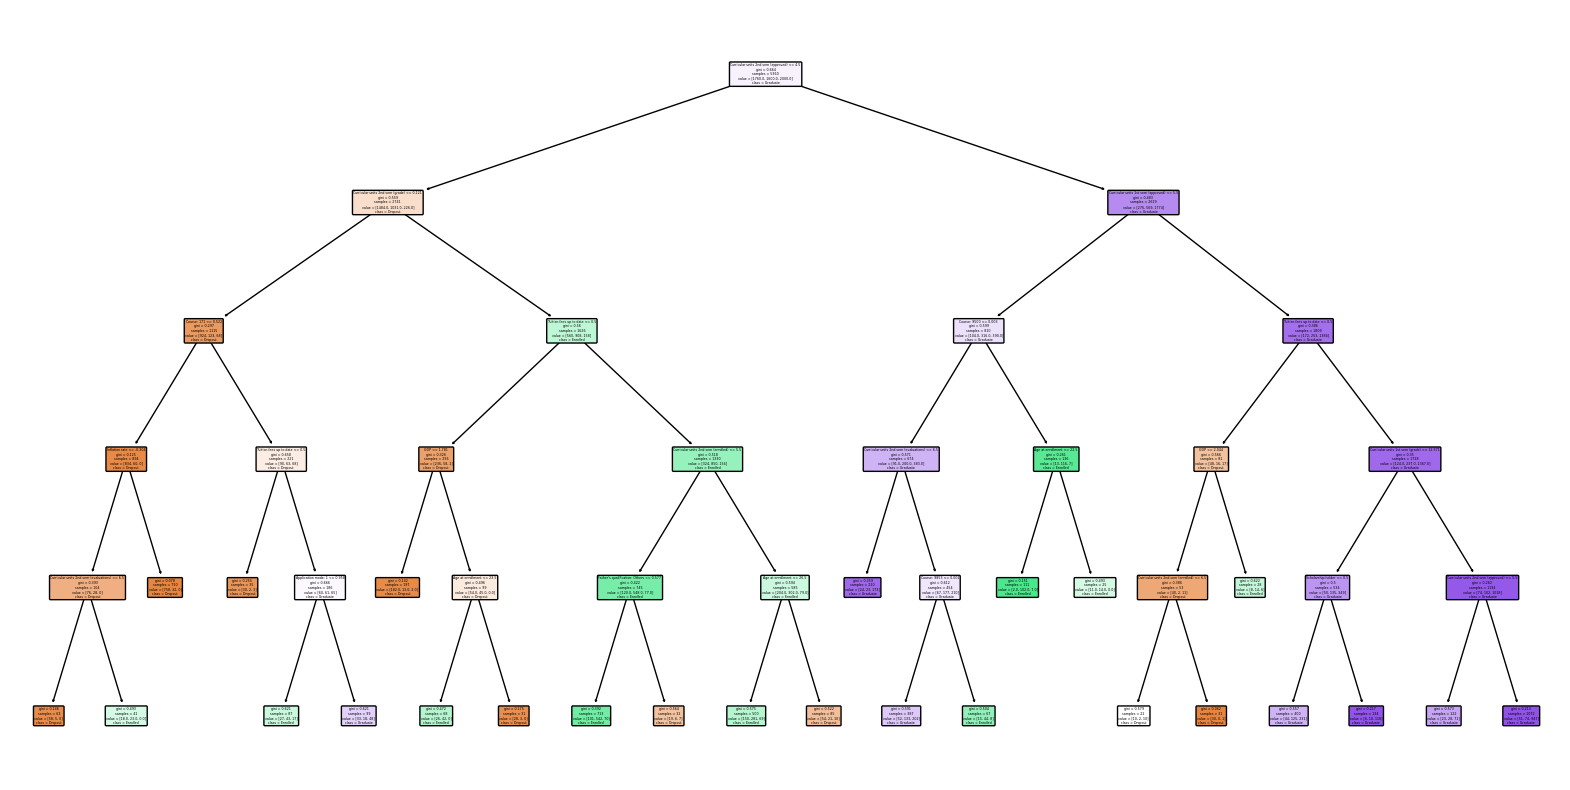

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'precision'

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='gini',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='gini',  # o 'entropy' si prefieres
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("gini_precision_tree.svg", format='svg')
plt.show()



## entropy tree: Best tree based on accuracy

Mejor configuración según accuracy :
max_depth             8.000000
min_samples_leaf     35.000000
min_samples_split    20.000000
accuracy              0.739552
Name: 168, dtype: float64


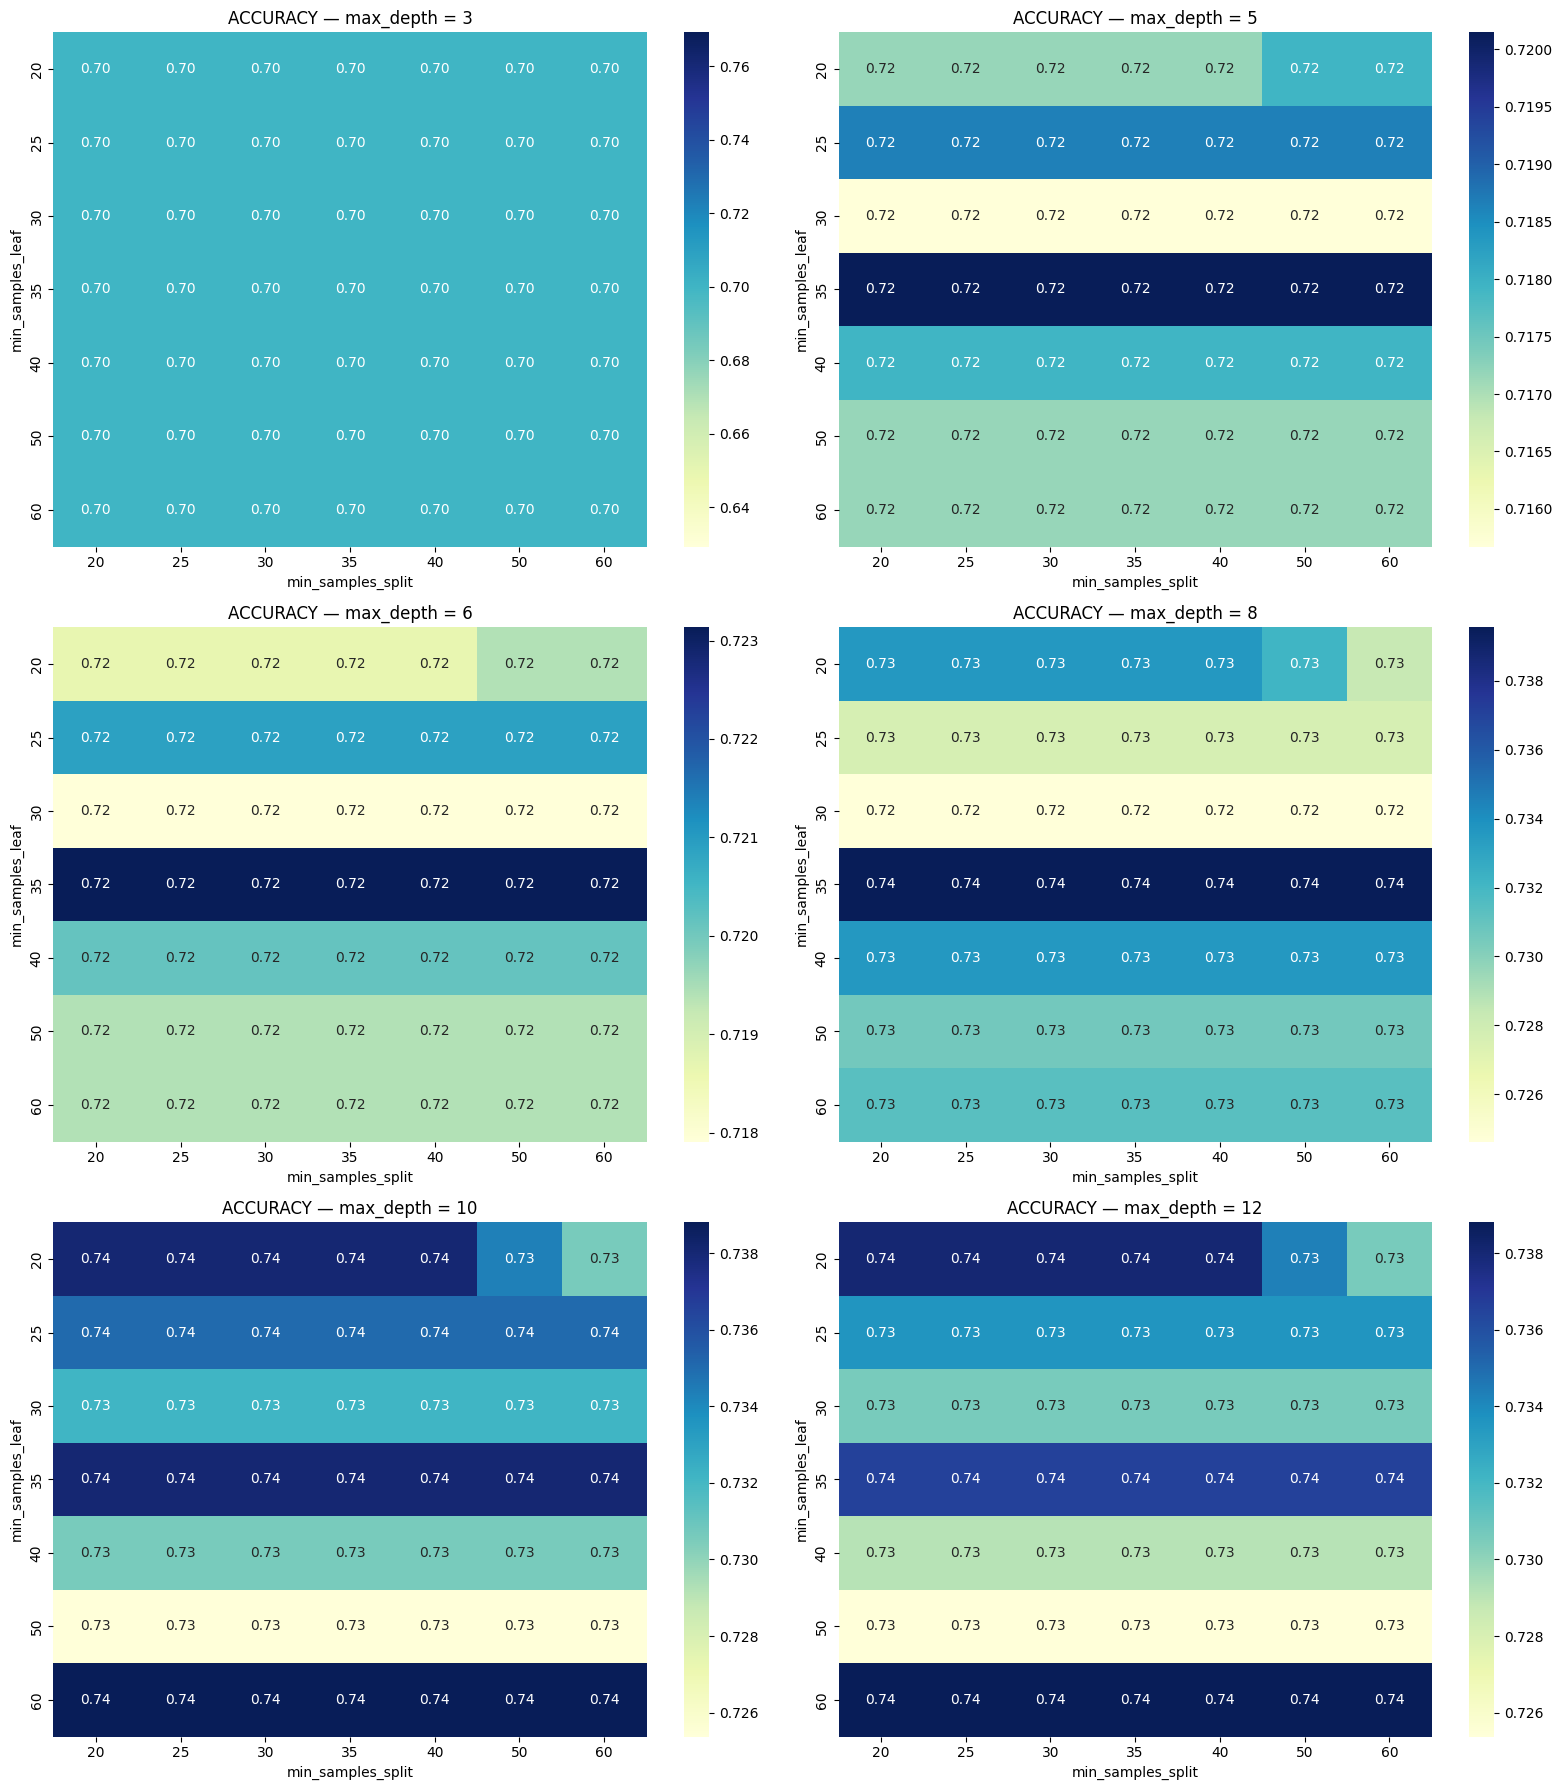


Accuracy del mejor modelo:
0.7395522388059701

Matriz de confusión del mejor modelo:
[[322  72  46]
 [ 60 240 100]
 [ 21  50 429]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.80      0.73      0.76       440
    Enrolled       0.66      0.60      0.63       400
    Graduate       0.75      0.86      0.80       500

    accuracy                           0.74      1340
   macro avg       0.74      0.73      0.73      1340
weighted avg       0.74      0.74      0.74      1340



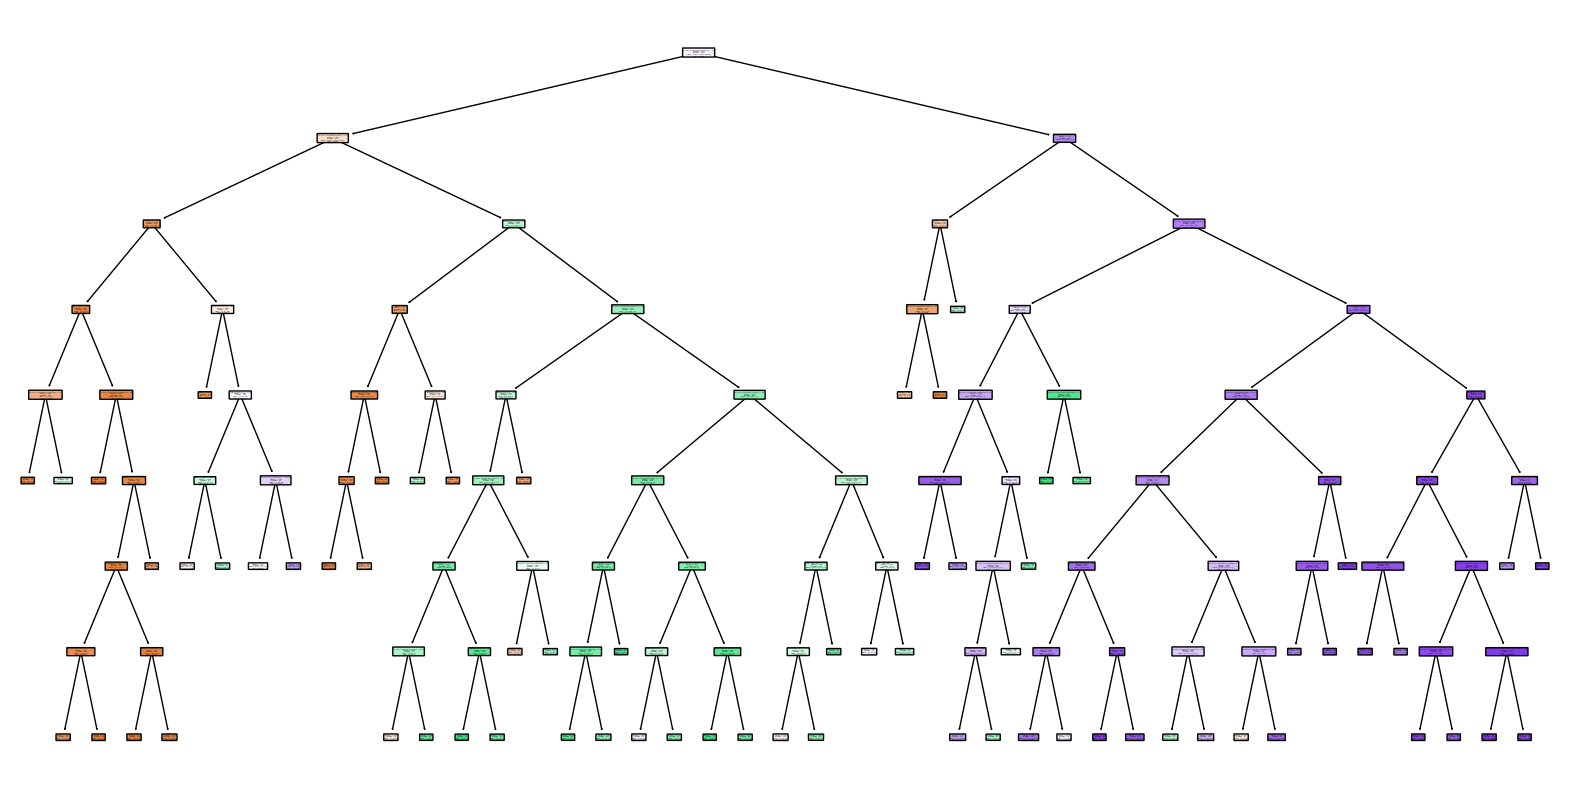

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'accuracy' 

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("entropy_accuracy_tree.svg", format='svg')
plt.show()



Mejor configuración según precision :
max_depth            10.000000
min_samples_leaf     20.000000
min_samples_split    20.000000
precision             0.742679
Name: 196, dtype: float64


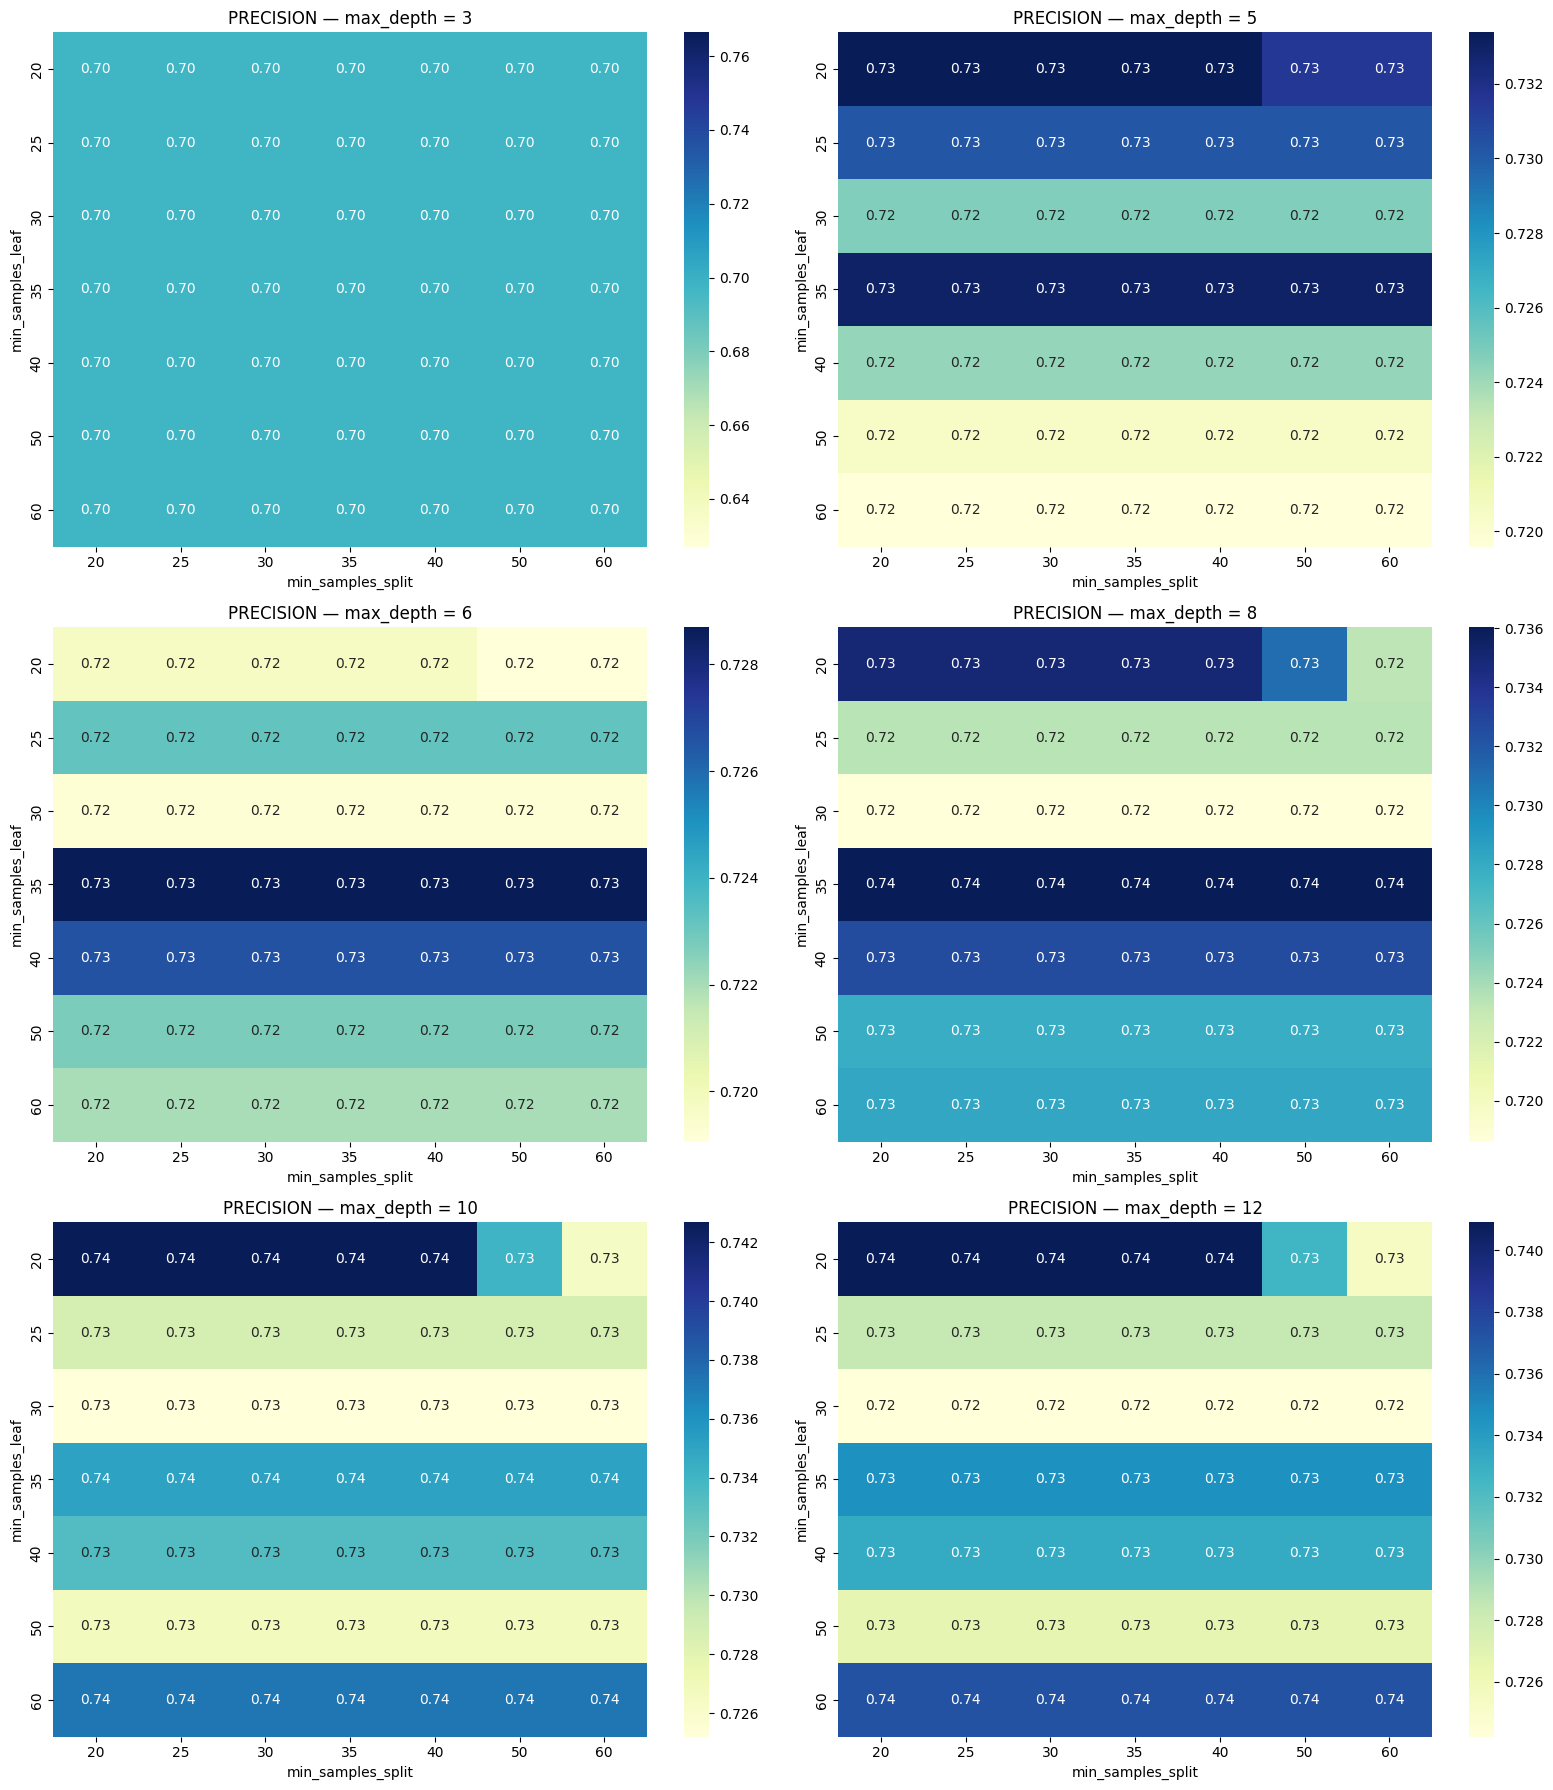


Accuracy del mejor modelo:
0.7380597014925373

Matriz de confusión del mejor modelo:
[[294 100  46]
 [ 44 276  80]
 [ 13  68 419]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.84      0.67      0.74       440
    Enrolled       0.62      0.69      0.65       400
    Graduate       0.77      0.84      0.80       500

    accuracy                           0.74      1340
   macro avg       0.74      0.73      0.73      1340
weighted avg       0.75      0.74      0.74      1340



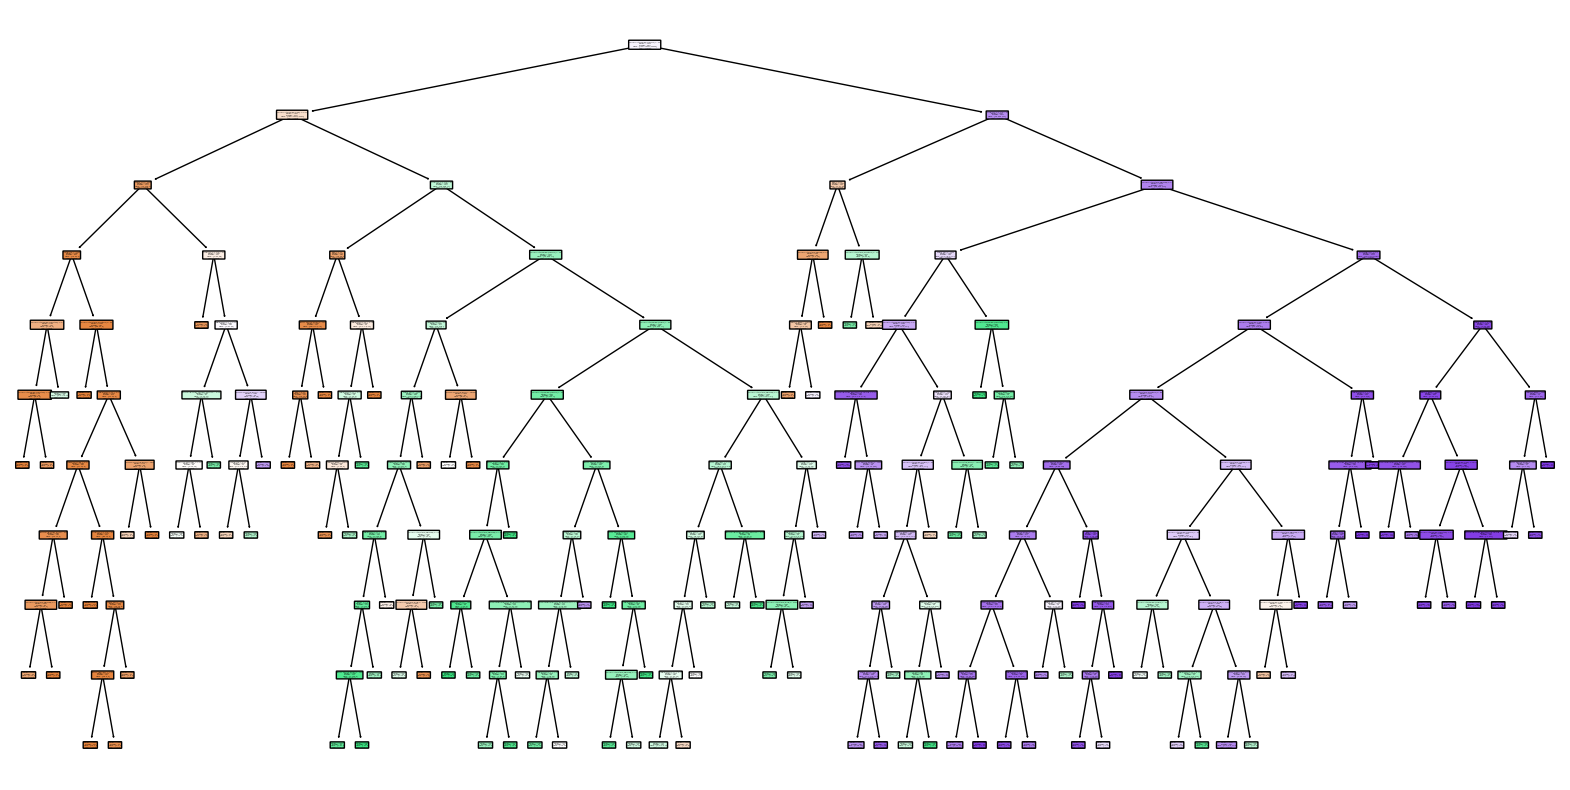

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'precision'  

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("entropy_precision_tree.svg", format='svg')
plt.show()



Mejor configuración según recall :
max_depth            12.000000
min_samples_leaf     20.000000
min_samples_split    20.000000
recall                0.732091
Name: 245, dtype: float64


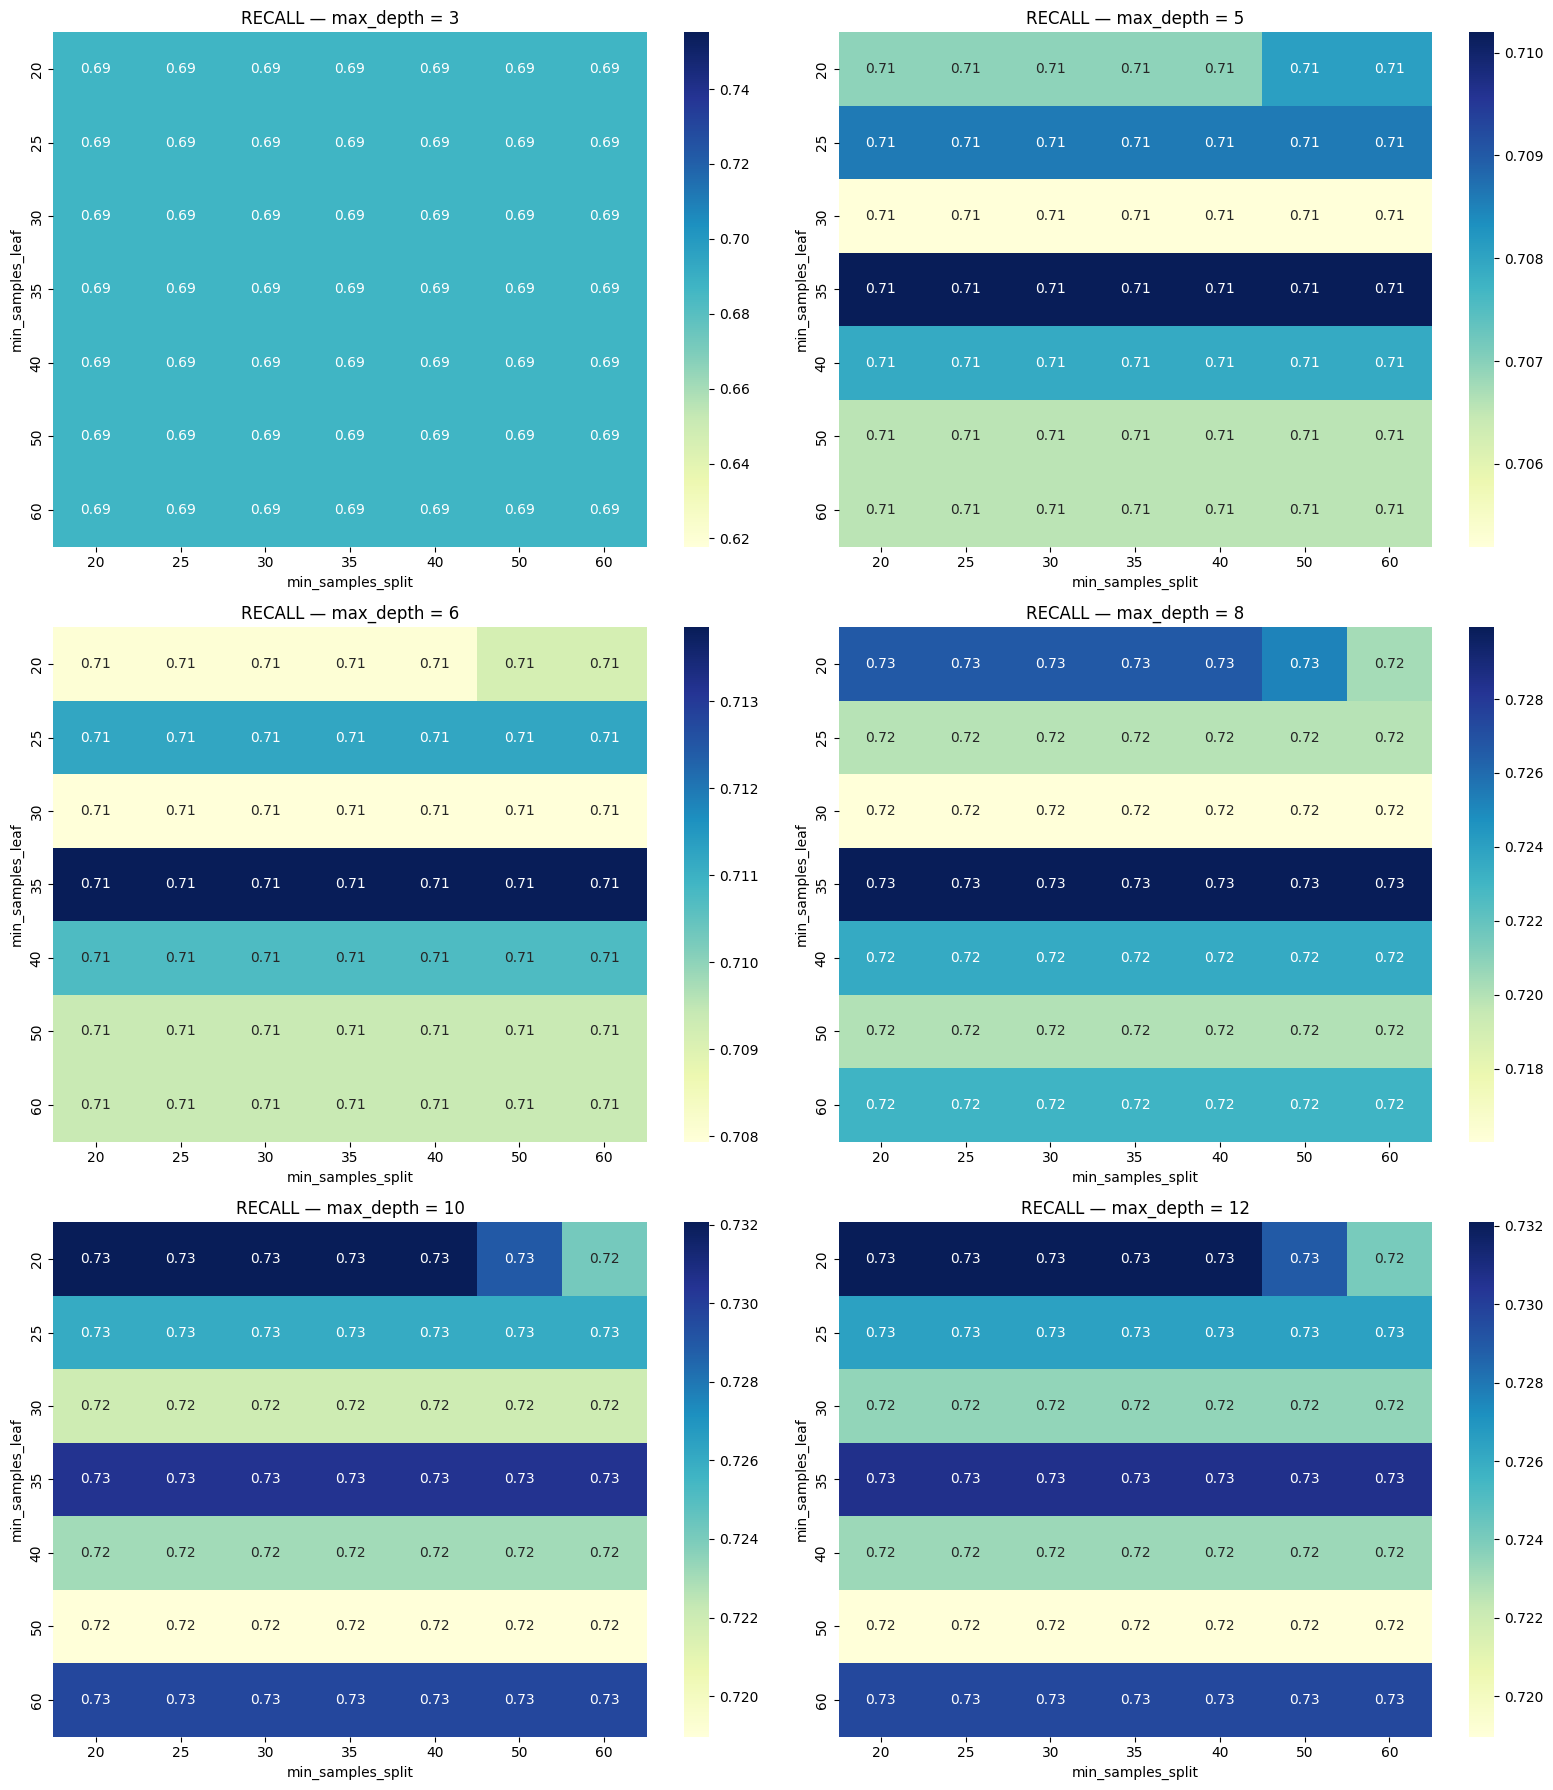


Accuracy del mejor modelo:
0.7380597014925373

Matriz de confusión del mejor modelo:
[[298  97  45]
 [ 48 274  78]
 [ 14  69 417]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.83      0.68      0.74       440
    Enrolled       0.62      0.69      0.65       400
    Graduate       0.77      0.83      0.80       500

    accuracy                           0.74      1340
   macro avg       0.74      0.73      0.73      1340
weighted avg       0.75      0.74      0.74      1340



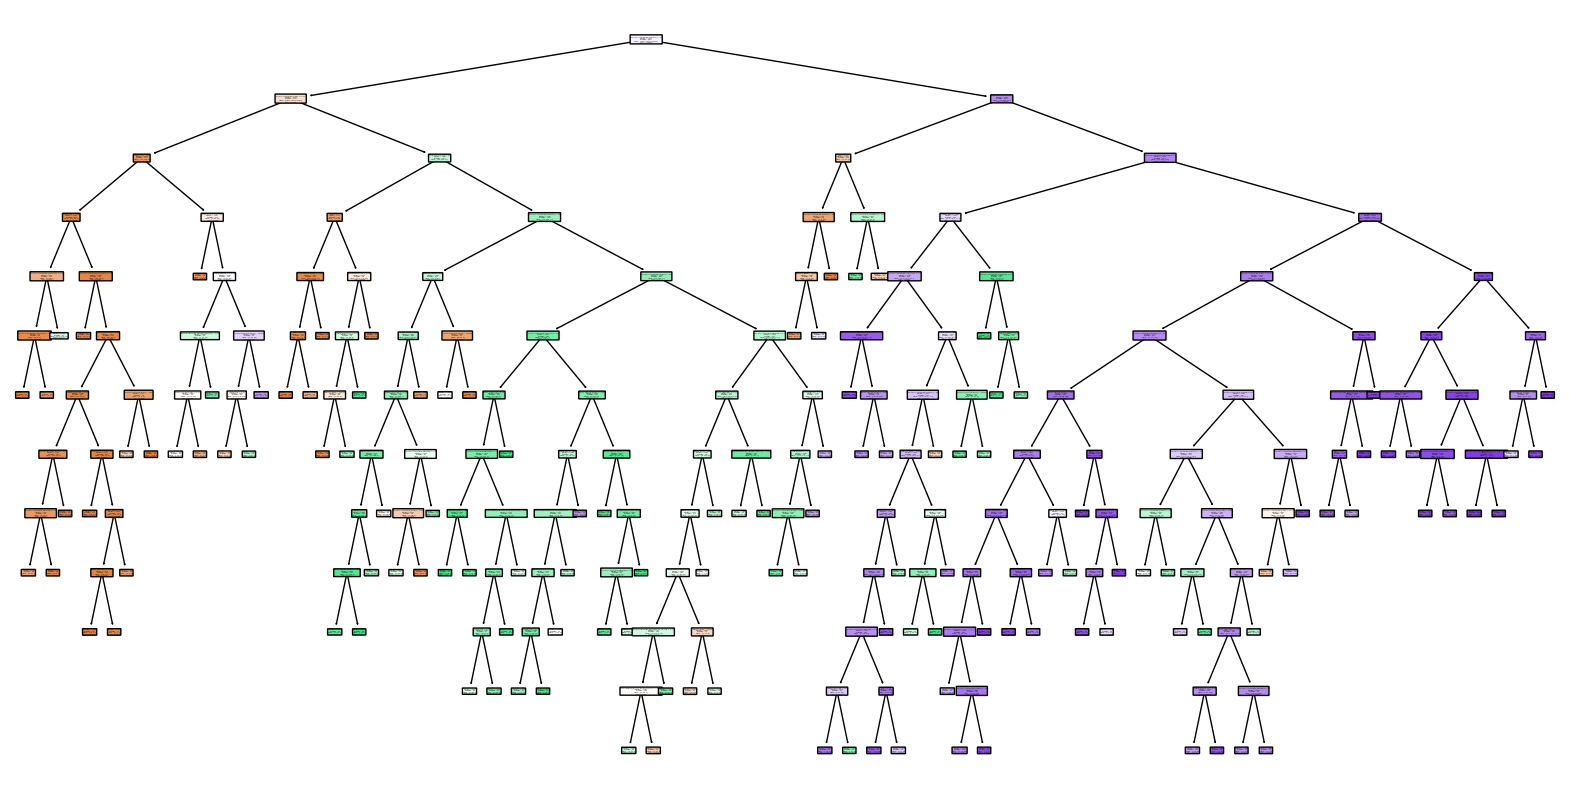

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'recall' 

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("entropy_recall_tree.svg", format='svg')
plt.show()



Mejor configuración según f1 :
max_depth            10.000000
min_samples_leaf     20.000000
min_samples_split    20.000000
f1                    0.733102
Name: 196, dtype: float64


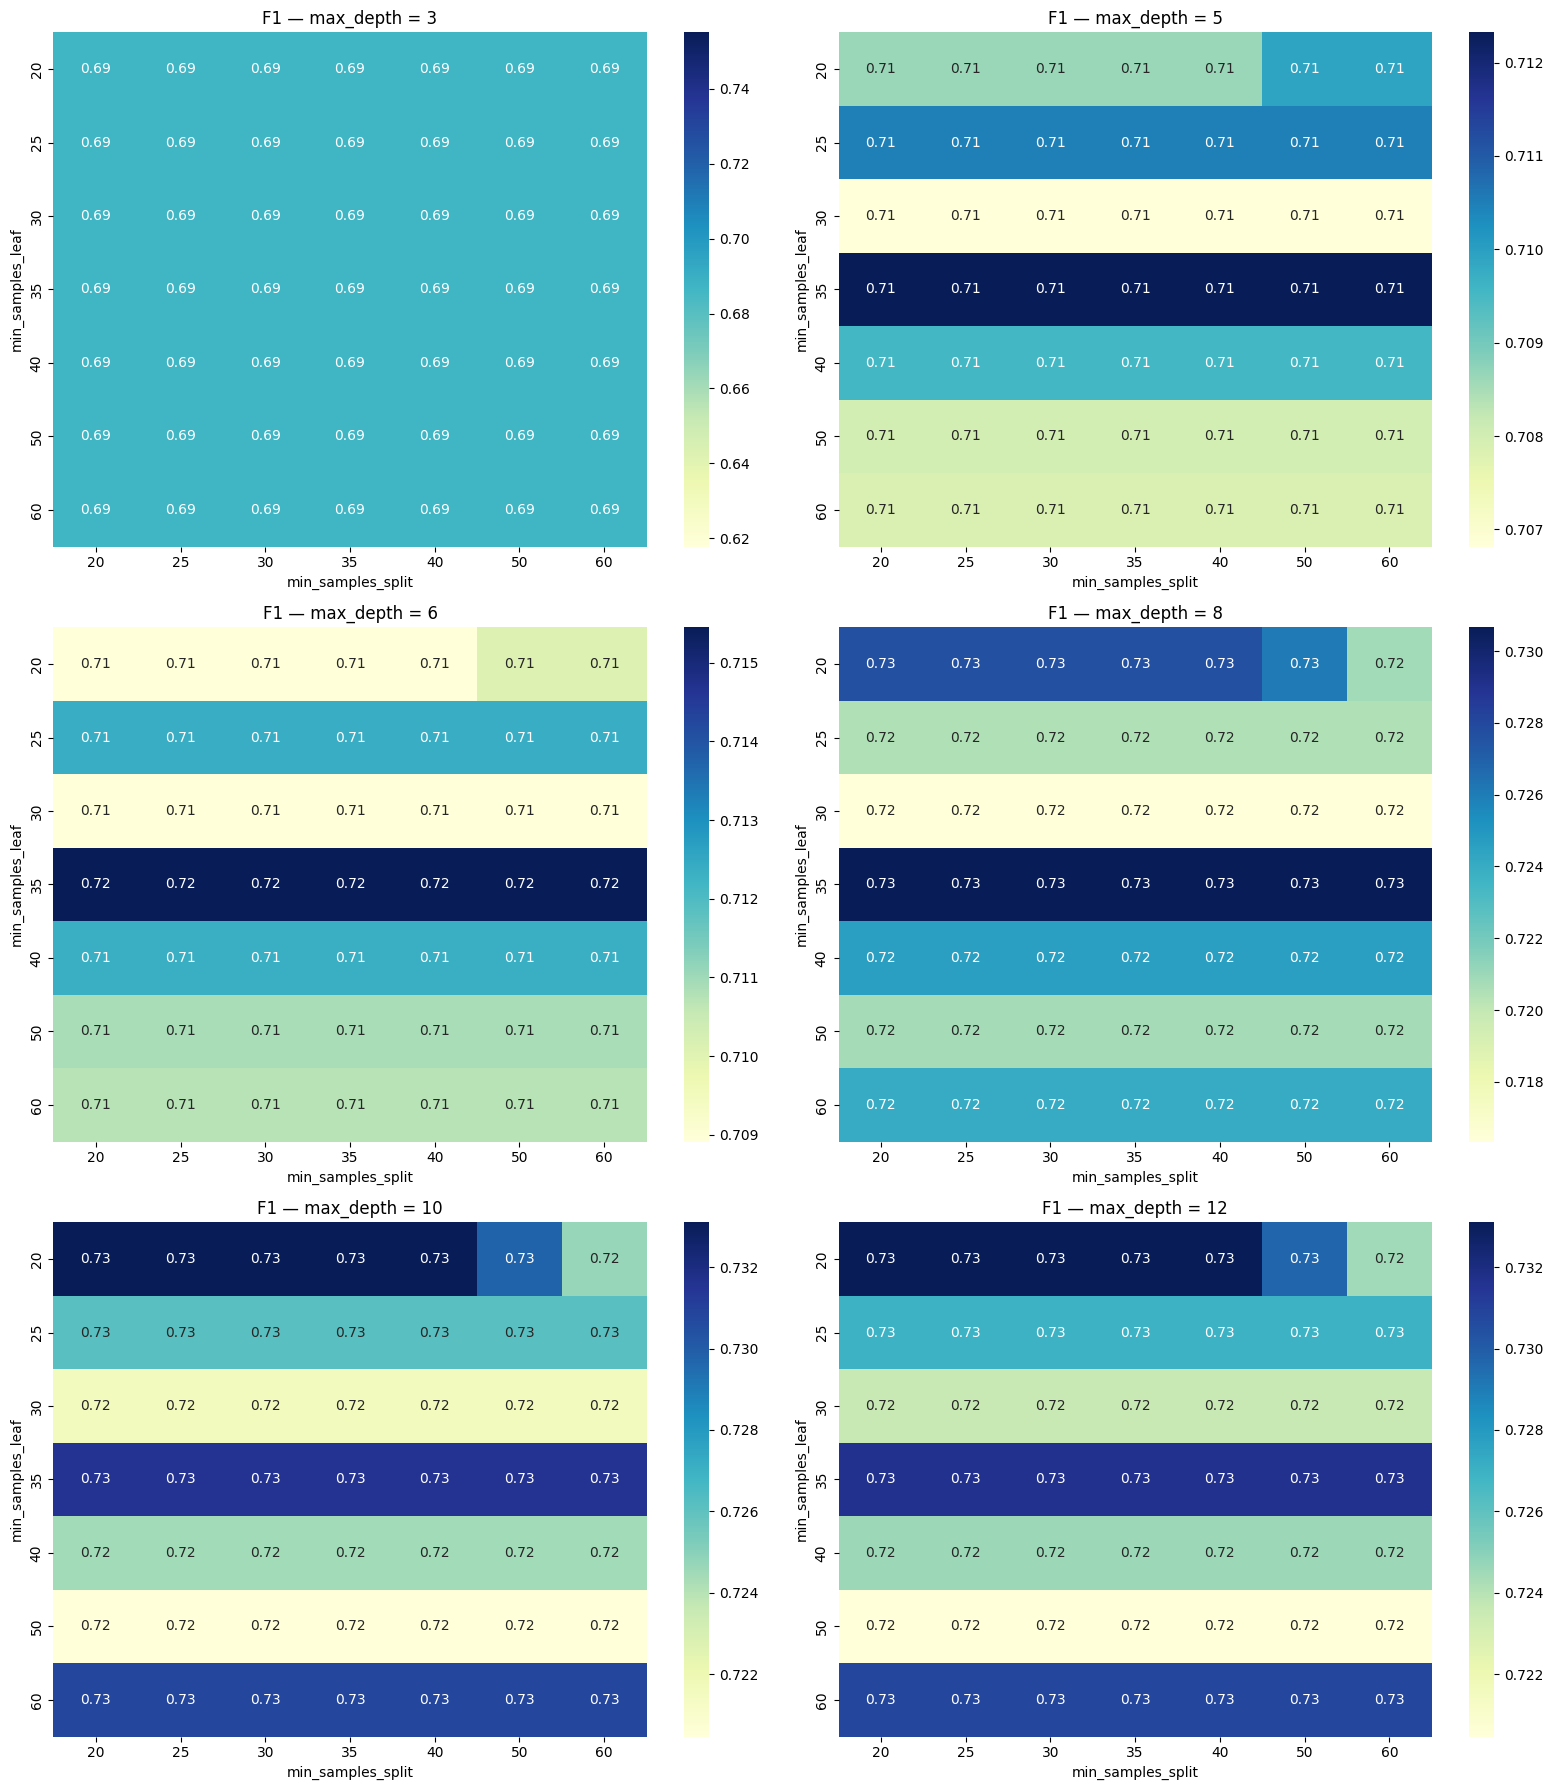


Accuracy del mejor modelo:
0.7380597014925373

Matriz de confusión del mejor modelo:
[[294 100  46]
 [ 44 276  80]
 [ 13  68 419]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.84      0.67      0.74       440
    Enrolled       0.62      0.69      0.65       400
    Graduate       0.77      0.84      0.80       500

    accuracy                           0.74      1340
   macro avg       0.74      0.73      0.73      1340
weighted avg       0.75      0.74      0.74      1340



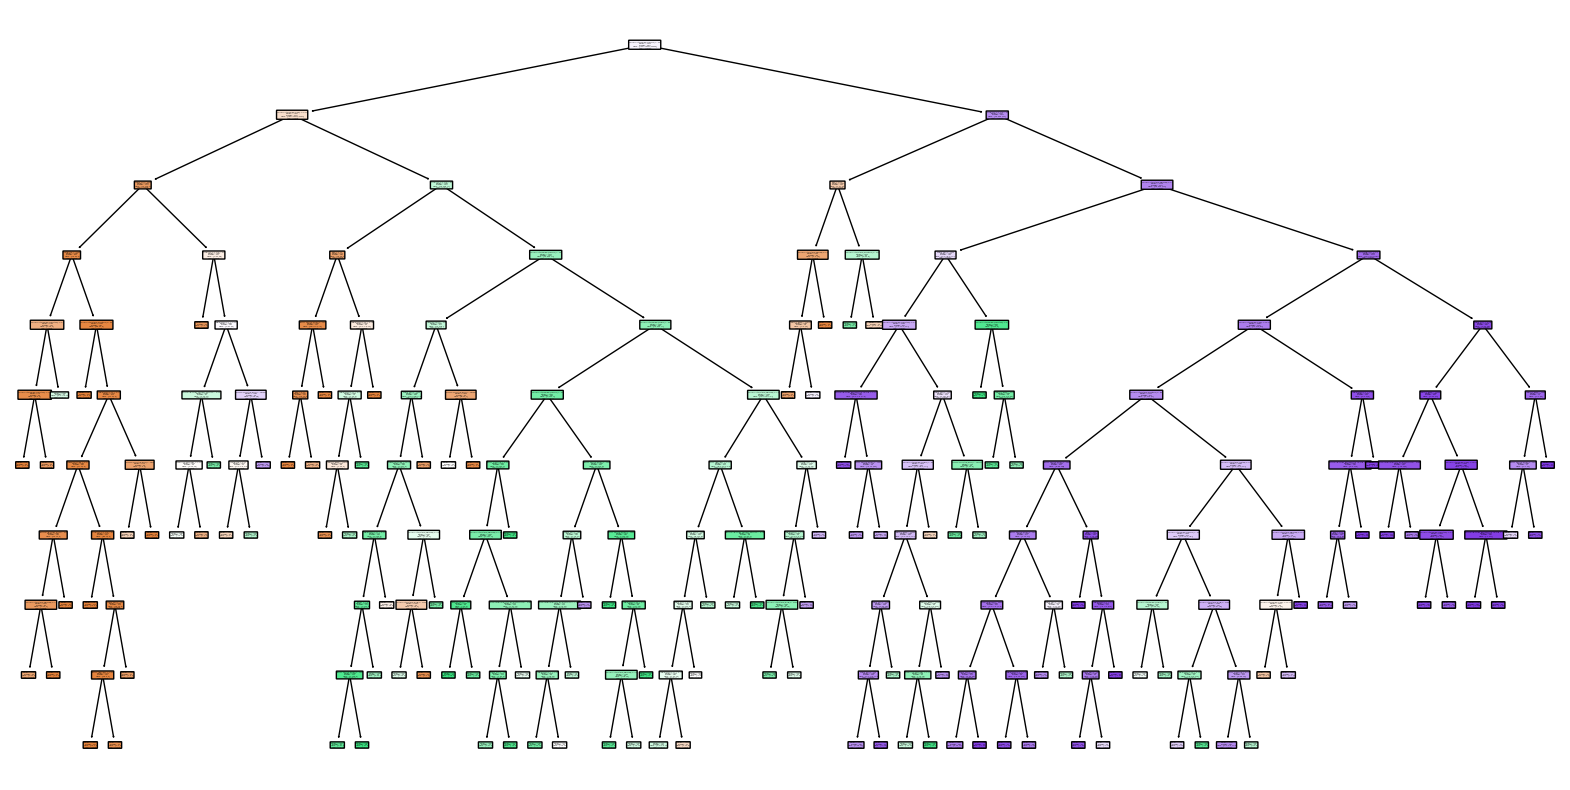

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall' o 'f1'
metric = 'f1' 

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print("Mejor configuración según", metric, ":")
print(best)

# Heatmaps de la métrica para cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Llamada al plot
tplot_heatmaps(df, depths, metric) if False else plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X.columns,
    class_names=target_names,
    filled=True,
    rounded=True
)
plt.savefig("entropy_f1_tree.svg", format='svg')
plt.show()



Mejor configuración según recall_dropout: {'max_depth': 10.0, 'min_samples_leaf': 30.0, 'min_samples_split': 20.0, 'recall_dropout': 0.740909090909091}


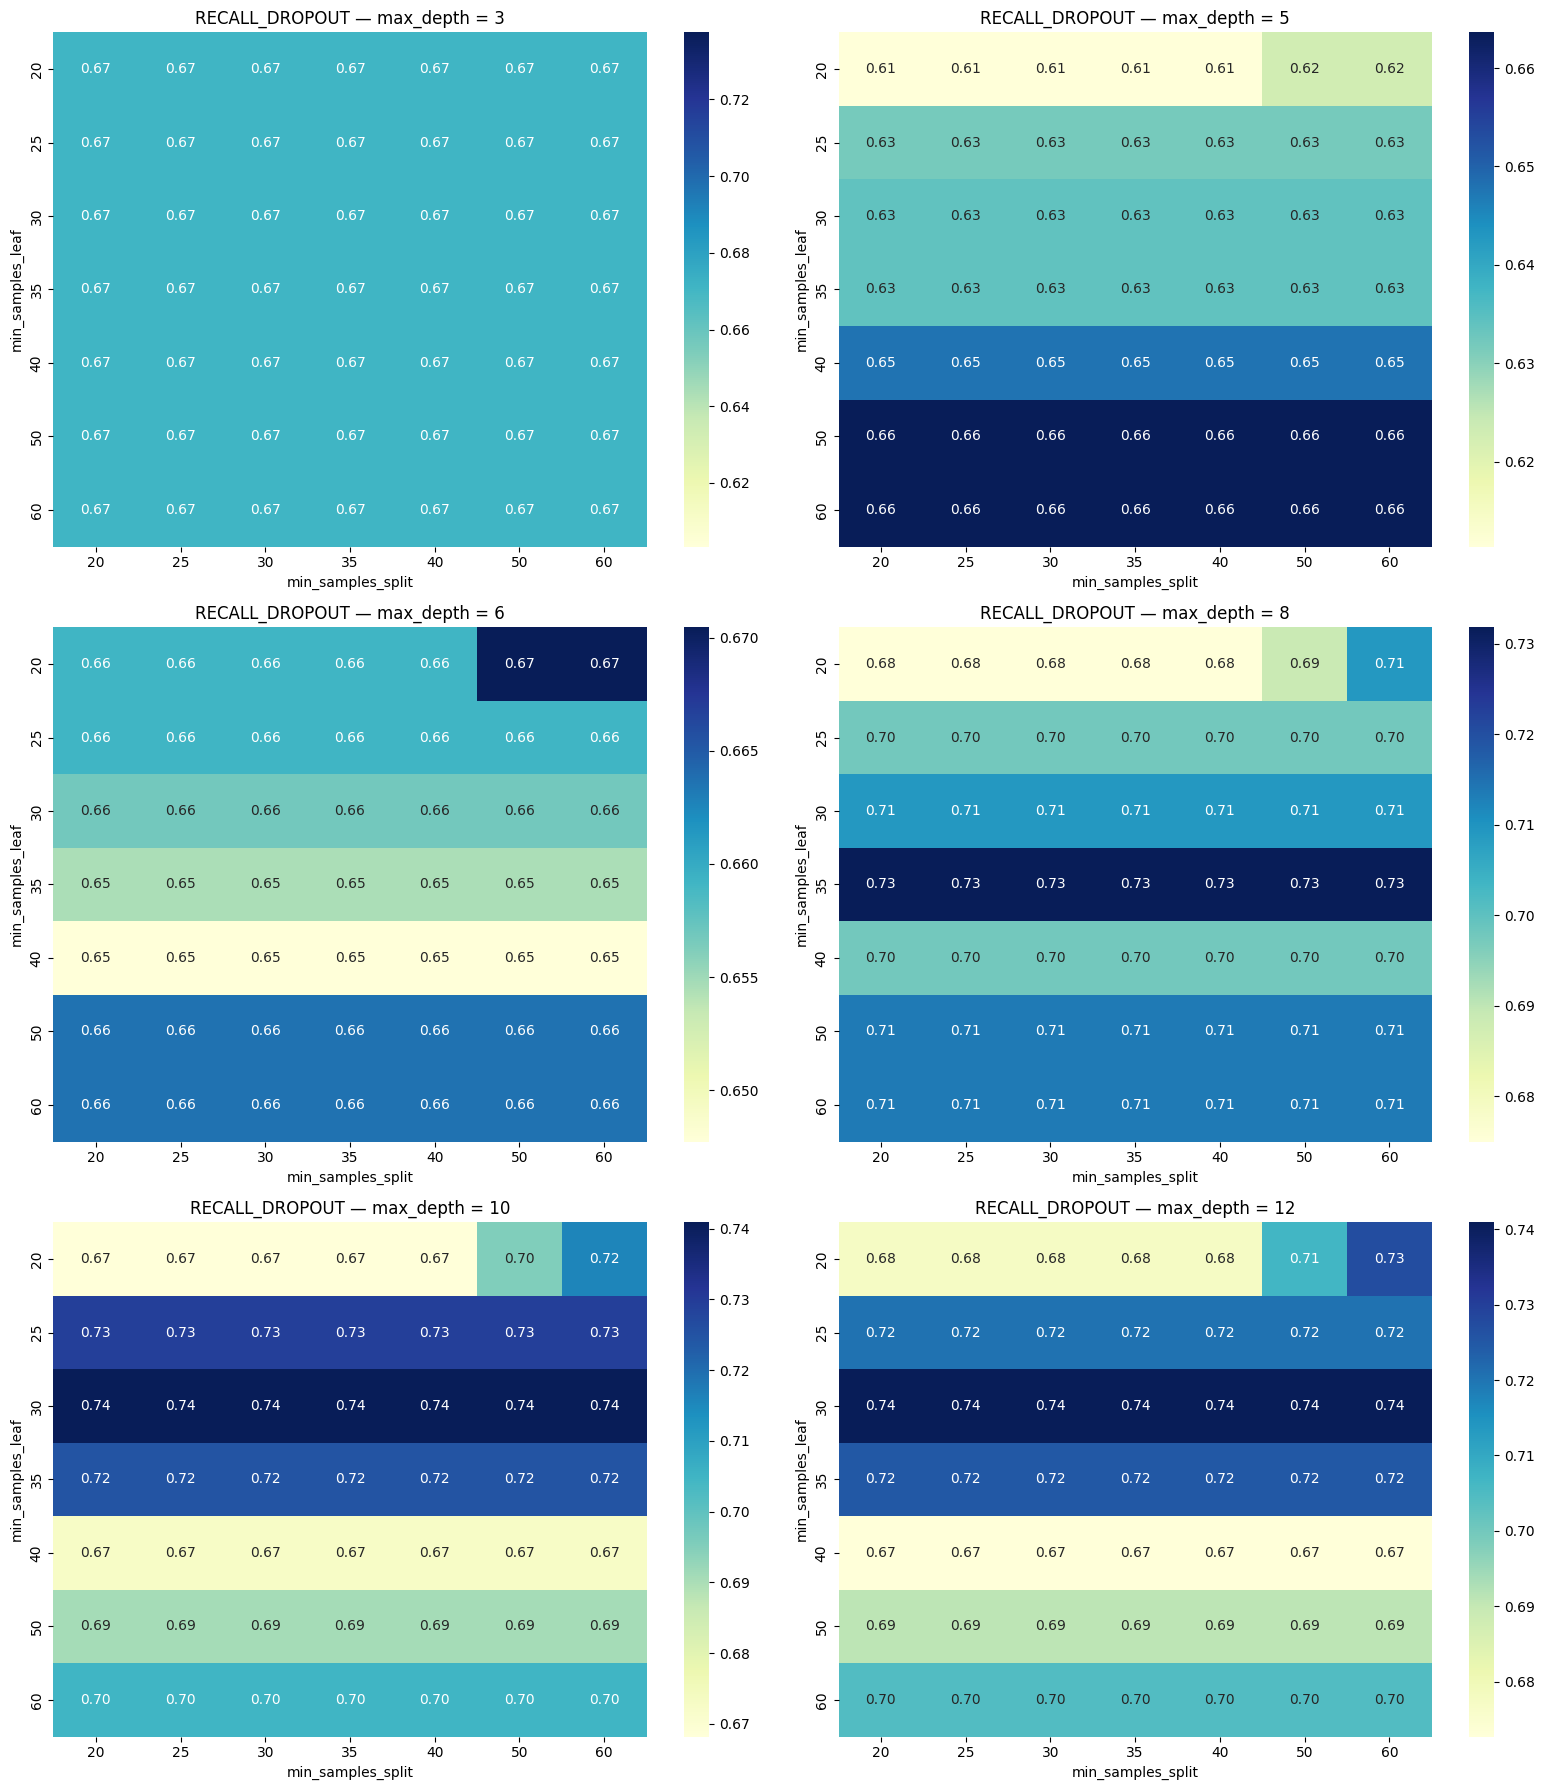


Accuracy del mejor modelo:
0.732089552238806

Matriz de confusión del mejor modelo:
[[326  68  46]
 [ 79 230  91]
 [ 27  48 425]]

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.75      0.74      0.75       440
    Enrolled       0.66      0.57      0.62       400
    Graduate       0.76      0.85      0.80       500

    accuracy                           0.73      1340
   macro avg       0.73      0.72      0.72      1340
weighted avg       0.73      0.73      0.73      1340



In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Asume que target_names está definido así:
# target_names = ['Dropout', 'Enrolled', 'Graduate']

# Hiperparámetros a probar
depths = [3, 5, 6, 8, 10, 12]
leaves = [20, 25, 30, 35, 40, 50, 60]
splits = [20, 25, 30, 35, 40, 50, 60]
# Métrica para seleccionar el mejor modelo: 'accuracy', 'precision', 'recall', 'f1' o 'recall_dropout'
metric = 'recall_dropout'  # prioriza la recall de la clase 'dropout'

# Función para calcular la métrica deseada
def get_score(y_true, y_pred, metric_name):
    # Incluir target_names para que las keys del reporte coincidan con los nombres legibles
    report = classification_report(y_true, y_pred, output_dict=True, target_names=target_names)
    if metric_name == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric_name == 'precision':
        return report['macro avg']['precision']
    elif metric_name == 'recall':
        return report['macro avg']['recall']
    elif metric_name == 'f1':
        return report['macro avg']['f1-score']
    elif metric_name == 'recall_dropout':
        # Extrae específicamente la recall para la clase 'Dropout'
        return report['Dropout']['recall']
    else:
        raise ValueError(f"Métrica desconocida: {metric_name}")

# DataFrame para almacenar resultados
results = []

for depth in depths:
    for leaf in leaves:
        for split in splits:
            # Crear y entrenar el árbol
            clf = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=depth,
                min_samples_leaf=leaf,
                min_samples_split=split,
                min_impurity_decrease=0.001,
                random_state=42
            )
            clf.fit(X_train, y_train)

            # Evaluación en test
            y_pred = clf.predict(X_test)
            score = get_score(y_test, y_pred, metric)

            results.append({
                'max_depth': depth,
                'min_samples_leaf': leaf,
                'min_samples_split': split,
                metric: score
            })

# Montar DataFrame y obtener mejor modelo
df = pd.DataFrame(results)
best = df.loc[df[metric].idxmax()]
print(f"Mejor configuración según {metric}: {best.to_dict()}")

# Función para dibujar heatmaps de la métrica por cada max_depth
def plot_heatmaps(df, depths, metric, cols=2):
    n = len(depths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes_flat = axes.flatten() if n > 1 else [axes]

    for i, depth in enumerate(depths):
        ax = axes_flat[i]
        pivot = df[df.max_depth == depth].pivot(
            index='min_samples_leaf',
            columns='min_samples_split',
            values=metric
        )
        sns.heatmap(pivot, annot=True, fmt=".2f", ax=ax, cmap='YlGnBu')
        ax.set_title(f"{metric.upper()} — max_depth = {depth}")
        ax.set_xlabel('min_samples_split')
        ax.set_ylabel('min_samples_leaf')

    # Ocultar ejes sobrantes
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.savefig("dt_tuning_heatmaps.svg", format='svg')
    plt.show()

# Generar los heatmaps
plot_heatmaps(df, depths, metric)

# Re-entrenar y mostrar reporte del mejor modelo
best_clf = DecisionTreeClassifier(
    criterion='entropy',  # 'entropy' para rutas interpretables
    max_depth=int(best.max_depth),
    min_samples_leaf=int(best.min_samples_leaf),
    min_samples_split=int(best.min_samples_split),
    min_impurity_decrease=0.001,
    random_state=42
)
best_clf.fit(X_train, y_train)
y_best = best_clf.predict(X_test)

# accuracy
print("\nAccuracy del mejor modelo:")
print(accuracy_score(y_test, y_best))
print("\nMatriz de confusión del mejor modelo:")
print(confusion_matrix(y_test, y_best))
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_best, target_names=target_names))


Aunque las métricas cuantitativas permanecen prácticamente idénticas, el valor diferencial radica en que el árbol regularizado:

- Es estructuralmente más limpio, con menos nodos redundantes.

- Elimina divisiones innecesarias que apenas aportan reducción de entropía.

- Evita hojas con pocos ejemplos, que suelen ser propensas a errores por ruido o outliers.

Esto hace que el modelo resultante sea más interpretable, más robusto y menos sensible a variaciones leves en los datos.

A pesar de que ambos árboles tienen el mismo rendimiento en términos de precisión y equilibrio entre clases, la versión con regularización adicional ofrece ventajas cualitativas clave. Su estructura es más compacta y menos propensa al sobreajuste, lo que facilita la interpretación de reglas de decisión y la justificación de acciones académicas. Este modelo resulta, por tanto, más apropiado para ser integrado en una herramienta de apoyo al seguimiento estudiantil, donde la simplicidad, transparencia y estabilidad son tan importantes como la precisión.



✅ Mejor alpha encontrado: 0.00205 con cross-val accuracy: 0.7444

🎯 Accuracy en test: 0.72

📊 Matriz de confusión:
[[273 115  52]
 [ 27 253 120]
 [  5  56 439]]

📄 Classification report:
              precision    recall  f1-score   support

     Dropout       0.90      0.62      0.73       440
    Enrolled       0.60      0.63      0.61       400
    Graduate       0.72      0.88      0.79       500

    accuracy                           0.72      1340
   macro avg       0.74      0.71      0.71      1340
weighted avg       0.74      0.72      0.72      1340



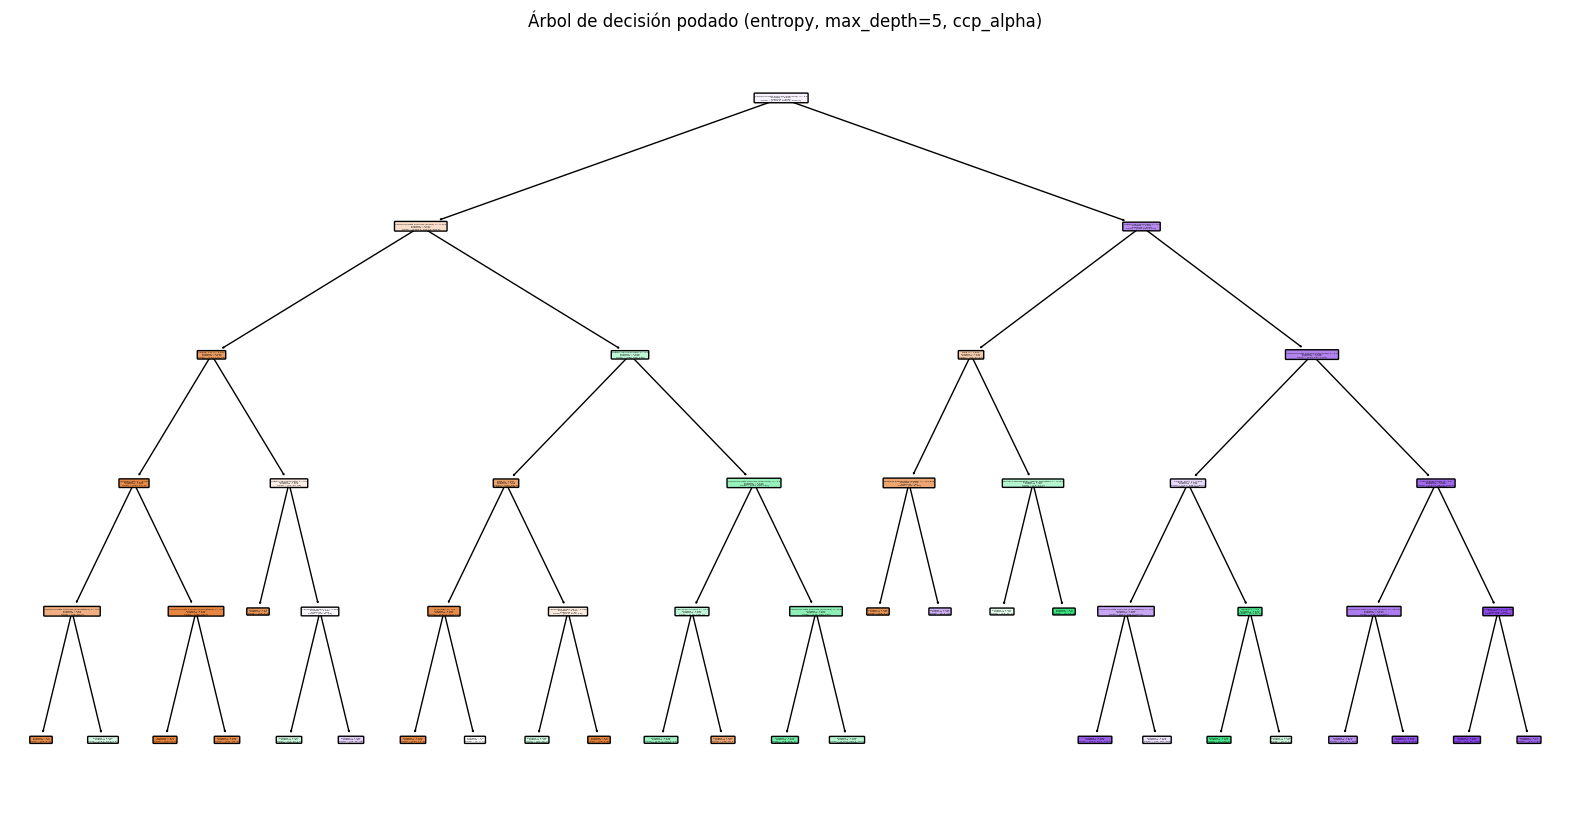

In [26]:
# Paso 1: Importar librerías necesarias
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Paso 2: Dividir los datos (si aún no lo hiciste)
X = features  # asegúrate de que 'features' contiene las columnas sin la variable objetivo
y = target    # 'target' debe ser el vector con Dropout (0), Enrolled (1), Graduate (2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Paso 3: Obtener la curva de complejidad (valores de ccp_alpha)
clf_base = DecisionTreeClassifier(criterion='entropy', 
                                max_depth=5, 
                                min_samples_leaf=50,
                                min_samples_split=50,
                                random_state=42)
path = clf_base.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Paso 4: Entrenar un árbol por cada valor de alpha y evaluar con validación cruzada
scores = []
models = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, ccp_alpha=alpha, random_state=42)
    clf.fit(X_train, y_train)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    scores.append(cv_score)
    models.append(clf)

# Paso 5: Encontrar el alpha con mejor puntuación
best_index = scores.index(max(scores))
best_alpha = ccp_alphas[best_index]
best_model = models[best_index]

print(f"✅ Mejor alpha encontrado: {best_alpha:.5f} con cross-val accuracy: {scores[best_index]:.4f}")

# Paso 6: Evaluar el modelo final en el conjunto de test
y_pred = best_model.predict(X_test)

print("\n🎯 Accuracy en test:", round(accuracy_score(y_test, y_pred), 2))
print("\n📊 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\n📄 Classification report:")
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

# Paso 7: Visualizar el árbol podado
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X.columns, class_names=['Dropout', 'Enrolled', 'Graduate'],
          filled=True, rounded=True)
plt.title("Árbol de decisión podado (entropy, max_depth=5, ccp_alpha)")
# save the tree in svg format
plt.savefig("tree_entropy_pruned.svg", format='svg')
plt.show()
